# <h2>Importación de librerias</h2>

In [1]:
# Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Operational Libraries
import pandas as pd
import re
import dask.dataframe as dd
import numpy as np

# <h2>1. Carga de datos desde excel a dataframes de pandas</h2>


En primer lugar voy a cargar cada uno de los csv a unos dataframes de pandas para ir manejandolos desde aqui. La idea es ir cruzando algunos excels y ver qué graficos interesantes van saliendo de los datos que tenemos. Los voy a cargar todos de una vez y a continuación los veremos en tablas para ir describiendolos

Esto puede tomar un ratito

In [2]:
df_tratamiento = pd.read_csv('Tratamiento.csv')

In [3]:
df_informacion_de_clientes = pd.read_csv('Informacion_Clientes.csv')

In [4]:
df_simulaciones_clientes = pd.read_csv('Simulaciones_Clientes.csv')

In [5]:
df_ventas = pd.read_csv('Ventas.csv')

In [6]:
df_simulaciones_clientes[df_simulaciones_clientes['Monto_Simulado'] < 0].count()
df_simulaciones_clientes = df_simulaciones_clientes[df_simulaciones_clientes['Monto_Simulado'] > 0]


<h3>1.1 Carga de 'Informacion_Clientes.csv'</h3>

En primer lugar se cargará la información de los clientes. Esto incluye las siguientes características de los clientes:

* **unnamed**: algo como uid
* **Rut**: identificador de Chile (supongo que por privacidad va desde 0 a max de observaciones)
* **Género**: Masculino o femenino
* **Categoría_Digital**: Si el cliente es digital o no
* **Elasticidad_Precios**: Baja, media o alta
* **Nacionalidad**: Chileno o extranjero
* **Propensión**: Número entre 0 y 1 que idica que tan propenso a cursar un credito es el cliente
* **Probabilidad_No_Pago**: Número entre 0 y 1 que indica la probabilidad de que el cliente no pague la deuda
* **Edad**: Numero entero de edad en años
* **Renta**: Renta promedio de los últimos 12 meses
* **Oferta_Consumo**: Monto máximo que puede cursar un cliente dado sus antecedentes crediticios y situación socioeconómica. 
* **Deuda_CMF**: Deuda que tiene el cliente en otros bancos. Efectivamente es deuda pendiente, pero de créditos otorgados por la competencia.
* **Tiempo_como_cliente**: Número de tiempo(no sé en que medida está) que el cliente lleva en el banco


In [7]:
# df_informacion_de_clientes['Genero'].nunique()

In [8]:
# tiempo_como_cliente_maximo = df_informacion_de_clientes['Tiempo_como_cliente'].max()
# tiempo_como_cliente_minimo =df_informacion_de_clientes['Tiempo_como_cliente'].max()
# print(f'Tiempo máximo como cliente: {tiempo_como_cliente_maximo}\nTiempo mínimo como cliente: {tiempo_como_cliente_minimo}')

<span style="color:cyan">Algo interesante es que tiempo como cliente es solamente '2'</span>

In [9]:
df_informacion_de_clientes.drop(columns=['Tiempo_como_cliente'], inplace=True)

<h3>1.2 Carga de 'Simulaciones_Clientes.csv'</h3>

En segundo lugar se cargaran las simulaciones hechas por los clientes en la página del banco. Esto incluye las siguientes características de las simulaciones:
* **unnamed**: Supongo que es el número de simulacion registrada, un tipo de identificador de la simulación
* **fecha**: yyyy-mm-dd fecha de la simulación
* **rut**: identificador de Chile del cliente que hizo la simulacion
* **monto_simulado**: monto prestado al cliente
* **plazo_simulado**: plazo en **meses** del crédito
* **tasa_simulado**: costo para el cliente del credito

Lo interesante es que con el rut se pueden cruzar el dataframe de informacion de cliente y del plazo simulado

<h3>1.3 Carga de 'Tratamiento.csv'</h3>

En tercer lugar se cargara el tratamiento que ha tenido el banco con el cliente, es decir, cómo se han contactado con él. Esto incluye las siguientes características:

* **unnamed**: Número de tratamiento registrado
* **fecha**: yyyy-mm-dd
* **rut**: Identificador de Chile del cliente con el que se tiene el tipo de trato
* **n_correos**: Cantidad de correos que se enviaron en el mes que sale la fecha. Es decir, si sele fecha '2024-03-01', correspondería a los correos enviados en marzo de 2024.
* **asg_ejec**: Si el cliente tiene un ejecutivo asignado

-[Notas de jp]: Este es el que más me costo entender, está registrado el tratamiento por fecha. Hay muchos más tratamientos(3 millones y medio) que clientes(500 mil clientes) por lo que supongo que el tipo de trato que le dan al cliente pudo haber cambiado en el tiempo. No estoy seguro si la cantidad de correos es un recuento del total de correos hasta la fecha o cuantos se les envió esa fecha.

<h3>1.4 Carga de 'Ventas.csv'</h3>

Por último se cargaran las ventas que ha tenido el banco con el cliente. Esto incluye las siguientes características:

* **unnamed**: Índice sin significado
* **fecha**: yyyy-mm-dd -> fecha en la que se concretó la venta
* **rut**: identificador de Chile del cliente al que se le concretó la venta

# <h2>2. Joints de datos<h2>


Ya con todos los df cargados se pueden ir cruzando algunos de ellos para poder ir sacando algunas conclusiones.

El primer joint que haré es la informacion de los clientes y la simulacion. 

Quiero saber: de todos mis clientes quienes son los que simulan. Por lo tanto, para cada uno de los clientes que exista en la base de informacion de clientes quiero tener la informacion de sus simulaciones (o no simulaciones es que no han simulado). Esto es interesante para saber si simulan o no.

In [10]:
df_simulaciones_e_informacion_de_clientes = pd.merge(
    df_informacion_de_clientes, 
    df_simulaciones_clientes, 
    on='rut', 
    how='left')

Revisaremos si hay algun NaN en este merge, es decir, si algún cliente no ha simulado.

In [11]:
df_simulaciones_e_informacion_de_clientes['Monto_Simulado'].isna().sum()

747

In [12]:
df_simulaciones_e_informacion_de_clientes[df_simulaciones_e_informacion_de_clientes['Monto_Simulado'].isna()]['rut'].nunique()

747

<span style="color:cyan">Hay 747 personas que nunca simularon.</span>

Esto lo agregaré como columna llamada simulo, que es binaria e indica si el cliente simuló o no.


In [13]:
df_simulaciones_e_informacion_de_clientes['simulo'] = df_simulaciones_e_informacion_de_clientes['Monto_Simulado'].notna().astype(int)

In [14]:
df_simulaciones_e_informacion_de_clientes.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)

In [15]:
df_simulaciones_e_informacion_de_clientes_ventas = pd.merge( 
    df_simulaciones_e_informacion_de_clientes, 
    df_ventas, 
    on=['rut', 'fecha'], 
    how='left'
    )

# 3. Procesamiento de tablas para ilan [ 1 ]
Tabla 1 (Ganancias): Necesito una tabla con todas las ventas, que tenga:

- fecha
- ⁠id cliente
- ⁠probabilidad no pago de ese cliente
- ⁠tasa
- ⁠monto
- ⁠plazo

In [16]:
df_simulaciones_e_informacion_de_clientes_ventas

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,fecha,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo,Unnamed: 0
0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2019-10-01,319936.0,33.0,1.092295,1,NaN
1,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2019-11-01,249773.0,30.0,2.324675,1,NaN
2,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2020-02-01,280087.0,28.0,1.051704,1,7864773.0
3,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2021-05-01,289780.0,26.0,2.193118,1,NaN
4,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2021-06-01,258061.0,22.0,2.188368,1,7864775.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517080,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-03-01,403331.0,17.0,2.356028,1,NaN
8517081,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-08-01,359897.0,16.0,2.478376,1,NaN
8517082,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-03-01,348048.0,18.0,2.301079,1,NaN
8517083,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-05-01,344504.0,16.0,2.462272,1,3871677.0


In [17]:
df_simulaciones_e_informacion_de_clientes_filtered = df_simulaciones_e_informacion_de_clientes_ventas[df_simulaciones_e_informacion_de_clientes_ventas['Unnamed: 0'].notna()]
tabla_ganancias = df_simulaciones_e_informacion_de_clientes_filtered[['rut','Probabilidad_No_Pago','Tasa_Simulado','fecha','Monto_Simulado','Plazo_Simulado']].copy()

tabla_ganancias

,rut,Probabilidad_No_Pago,Tasa_Simulado,fecha,Monto_Simulado,Plazo_Simulado
2,1,0.028445,1.051704,2020-02-01,280087.0,28.0
4,1,0.028445,2.188368,2021-06-01,258061.0,22.0
8,1,0.028445,2.343216,2022-08-01,249106.0,34.0
10,1,0.028445,2.358720,2023-04-01,236814.0,32.0
12,1,0.028445,1.203271,2023-10-01,286611.0,24.0
...,...,...,...,...,...,...
8517073,543651,0.019647,1.282082,2021-05-01,363738.0,18.0
8517077,543651,0.019647,1.103655,2022-06-01,316063.0,15.0
8517079,543651,0.019647,2.337312,2023-02-01,386646.0,16.0
8517083,543651,0.019647,2.462272,2024-05-01,344504.0,16.0


# 3.2 Procesamiento de tablas para ilan [ 2 ]
Tabla 2 (créditos y correos): Necesito que me envíes por mes una tabla con:

- id cliente
- ⁠mes
- ⁠créditos simulados
- ⁠créditos aprobados
- ⁠correos enviados
- asignacion de ejecutivo

In [18]:
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento = pd.merge( 
    df_simulaciones_e_informacion_de_clientes_ventas, 
    df_tratamiento, 
    on=['rut', 'fecha'], 
    how='left'
    )

In [19]:
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento.rename(columns={'Unnamed: 0_x': 'venta'}, inplace=True)
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['venta'] = df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['venta'].notna().astype(int)
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,fecha,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo,venta,Unnamed: 0_y,n_correos,asg_ejec
0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2019-10-01,319936.0,33.0,1.092295,1,0,0.0,2.0,0.0
1,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2019-11-01,249773.0,30.0,2.324675,1,0,0.0,0.0,0.0
2,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2020-02-01,280087.0,28.0,1.051704,1,1,0.0,1.0,0.0
3,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2021-05-01,289780.0,26.0,2.193118,1,0,0.0,1.0,0.0
4,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2021-06-01,258061.0,22.0,2.188368,1,1,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517080,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-03-01,403331.0,17.0,2.356028,1,0,543650.0,2.0,1.0
8517081,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-08-01,359897.0,16.0,2.478376,1,0,543650.0,2.0,0.0
8517082,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-03-01,348048.0,18.0,2.301079,1,0,543650.0,4.0,0.0
8517083,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-05-01,344504.0,16.0,2.462272,1,1,543650.0,0.0,1.0


In [20]:
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['mes'] = pd.to_datetime(df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['fecha']).dt.to_period('M')

tabla_creditos_correos = df_simulaciones_e_informacion_de_clientes_ventas_tratamiento.groupby(['rut', 'mes']).agg({
    'Monto_Simulado': 'count',
    'venta': 'sum',
    'n_correos': 'sum',
    'asg_ejec': 'max'
}).reset_index()

tabla_creditos_correos.rename(columns={
    'rut': 'id cliente',
    'Monto_Simulado': 'créditos simulados',
    'venta': 'créditos aprobados',
    'n_correos': 'correos enviados',
    'asg_ejec': 'asignacion de ejecutivo'
}, inplace=True)

tabla_creditos_correos

,id cliente,mes,créditos simulados,créditos aprobados,correos enviados,asignacion de ejecutivo
0,1,2019-10,1,0,2.0,0.0
1,1,2019-11,1,0,0.0,0.0
2,1,2020-02,1,1,1.0,0.0
3,1,2021-05,1,0,1.0,0.0
4,1,2021-06,1,1,3.0,0.0
...,...,...,...,...,...,...
8516333,543651,2023-03,1,0,2.0,1.0
8516334,543651,2023-08,1,0,2.0,0.0
8516335,543651,2024-03,1,0,4.0,0.0
8516336,543651,2024-05,1,1,0.0,1.0


In [21]:
# tabla_creditos_correos.to_csv('df_to_ilan_2_with_ejec.csv', index=False)


In [22]:
df_informacion_de_clientes.to_csv('df_informacion_de_clientes_updaetd.csv', index=False)

# 3.5 Tratamiento que no simuló

In [23]:
df_clientes_que_no_simulan = df_simulaciones_e_informacion_de_clientes[df_simulaciones_e_informacion_de_clientes['simulo'] == 0]
df_clientes_que_no_simulan

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,fecha,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo
12137,780,Femenino,Cliente Digital,Alta,Chileno,0.307640,0.007871,31.0,4.744469e+05,1117352.0,4.317737e+05,NaN,NaN,NaN,NaN,0
32403,2082,Femenino,Cliente Digital,Media,Chileno,0.505345,0.025828,27.0,7.642129e+05,2078877.0,9.941304e+05,NaN,NaN,NaN,NaN,0
53352,3403,Masculino,Cliente Digital,Baja,Chileno,0.860546,0.013709,28.0,5.206620e+04,110955.0,6.067930e+04,NaN,NaN,NaN,NaN,0
80728,5150,Femenino,Cliente Digital,Media,Chileno,0.375278,0.029899,29.0,4.578795e+06,9640006.0,5.446584e+06,NaN,NaN,NaN,NaN,0
94914,6060,Masculino,Cliente Digital,Alta,Chileno,0.422165,0.053365,27.0,7.495721e+05,1953276.0,8.010537e+05,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475532,540942,Femenino,Cliente no Digital,Alta,Extranjero,0.145846,0.015207,29.0,6.282168e+06,17959862.0,7.883997e+06,NaN,NaN,NaN,NaN,0
8490307,541897,Masculino,Cliente no Digital,Baja,Chileno,0.433438,0.010885,47.0,7.916352e+06,10614996.0,7.610865e+06,NaN,NaN,NaN,NaN,0
8495217,542225,Femenino,Cliente Digital,Alta,Chileno,0.511740,0.030114,31.0,8.167334e+05,3469995.0,7.542526e+05,NaN,NaN,NaN,NaN,0
8496664,542322,Masculino,Cliente no Digital,Alta,Chileno,0.828991,0.029804,29.0,9.794209e+05,3549490.0,8.051102e+05,NaN,NaN,NaN,NaN,0


In [24]:
df_clientes_que_no_simulan.describe()

,rut,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo
count,747.000000,747.000000,747.000000,747.000000,7.470000e+02,7.470000e+02,7.470000e+02,0.0,0.0,0.0,747.0
mean,279735.147256,0.502508,0.020988,31.068273,1.726504e+06,6.700486e+06,1.745132e+06,NaN,NaN,NaN,0.0
std,158062.373498,0.284599,0.015538,5.179812,4.942094e+06,2.882054e+07,5.062681e+06,NaN,NaN,NaN,0.0
min,780.000000,0.000093,0.000006,25.000000,1.123287e+03,2.214000e+03,5.646986e+02,NaN,NaN,NaN,0.0
25%,147122.000000,0.271560,0.008383,29.000000,3.073471e+05,7.936645e+05,2.856043e+05,NaN,NaN,NaN,0.0
50%,281422.000000,0.494136,0.018703,30.000000,7.184987e+05,1.909540e+06,6.908328e+05,NaN,NaN,NaN,0.0
75%,419937.500000,0.750950,0.029896,32.000000,1.499324e+06,4.196426e+06,1.457513e+06,NaN,NaN,NaN,0.0
max,543624.000000,0.997085,0.069568,63.000000,6.620296e+07,4.499284e+08,6.043560e+07,NaN,NaN,NaN,0.0


In [25]:
df_clientes_que_no_simulan_tratamiento = pd.merge(df_clientes_que_no_simulan, df_tratamiento, on=['rut'], how='left')

In [26]:
df_clientes_que_no_simulan_tratamiento.describe()

,rut,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo,Unnamed: 0,n_correos,asg_ejec
count,49302.000000,49302.000000,49302.000000,49302.000000,4.930200e+04,4.930200e+04,4.930200e+04,0.0,0.0,0.0,49302.0,49302.000000,49302.000000,49302.000000
mean,279735.147256,0.502508,0.020988,31.068273,1.726504e+06,6.700486e+06,1.745132e+06,NaN,NaN,NaN,0.0,279734.147256,2.317959,0.340980
std,157958.141911,0.284411,0.015528,5.176396,4.938835e+06,2.880153e+07,5.059343e+06,NaN,NaN,NaN,0.0,157958.141911,1.319536,0.474043
min,780.000000,0.000093,0.000006,25.000000,1.123287e+03,2.214000e+03,5.646986e+02,NaN,NaN,NaN,0.0,779.000000,0.000000,0.000000
25%,145851.000000,0.271351,0.008380,29.000000,3.072792e+05,7.933310e+05,2.828713e+05,NaN,NaN,NaN,0.0,145850.000000,1.000000,0.000000
50%,281422.000000,0.494136,0.018703,30.000000,7.184987e+05,1.909540e+06,6.908328e+05,NaN,NaN,NaN,0.0,281421.000000,2.000000,0.000000
75%,419985.000000,0.752659,0.029899,32.000000,1.499854e+06,4.199411e+06,1.462403e+06,NaN,NaN,NaN,0.0,419984.000000,4.000000,1.000000
max,543624.000000,0.997085,0.069568,63.000000,6.620296e+07,4.499284e+08,6.043560e+07,NaN,NaN,NaN,0.0,543623.000000,4.000000,1.000000


# 4. Procesamiento de tablas para calculo del revenue pasado

# 5. Procesamiento para clustering con kmeans

In [27]:
df_simulaciones_e_informacion_de_clientes_ventas['venta'] = df_simulaciones_e_informacion_de_clientes_ventas['Unnamed: 0'].notna().astype(int)

In [28]:
df_simulaciones_e_informacion_de_clientes_ventas.drop(columns=['Unnamed: 0'], inplace=True)

In [29]:
datos_deventas_y_simulaciones = df_simulaciones_e_informacion_de_clientes_ventas.groupby('rut').agg({'simulo': 'sum', 'venta': 'sum'})

In [30]:
datos_deventas_y_simulaciones.reset_index(drop=True, inplace=True)


In [31]:
df_informacion_de_clientes['cantidad simulaciones'] = datos_deventas_y_simulaciones['simulo']
df_informacion_de_clientes['cantidad de ventas'] = datos_deventas_y_simulaciones['venta']
df_informacion_de_clientes['tasa de concresion'] = df_informacion_de_clientes['cantidad de ventas'] / df_informacion_de_clientes['cantidad simulaciones']

In [32]:
df_informacion_de_clientes['tasa de concresion'].fillna(0, inplace=True)

In [33]:
df_informacion_de_clientes_mapped = df_informacion_de_clientes.copy()

df_informacion_de_clientes_mapped['Genero'] = df_informacion_de_clientes['Genero'].map({'Masculino': 1, 'Femenino': 0})
df_informacion_de_clientes_mapped['Categoria_Digital'] = df_informacion_de_clientes['Categoria_Digital'].map({'Cliente Digital': 1, 'Cliente no Digital': 0})
df_informacion_de_clientes_mapped['Elasticidad_Precios'] = df_informacion_de_clientes['Elasticidad_Precios'].map({'Alta': 3, 'Media': 2, 'Baja': 1})
df_informacion_de_clientes_mapped['Nacionalidad'] = df_informacion_de_clientes['Nacionalidad'].map({'Chileno': 1, 'Extranjero': 0})

df_informacion_de_clientes_mapped


,Unnamed: 0,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,cantidad simulaciones,cantidad de ventas,tasa de concresion
0,0,1,1,0,3,1,0.997340,0.028445,30.0,6.258183e+05,2164276.0,7.125854e+05,15,5,0.333333
1,1,2,0,0,1,1,0.291601,0.014320,41.0,3.172616e+05,1451704.0,1.970697e+05,10,2,0.200000
2,2,3,0,0,1,1,0.685085,0.002156,38.0,1.240551e+07,39322607.0,1.400604e+07,20,4,0.200000
3,3,4,1,0,3,1,0.914672,0.034418,57.0,5.441466e+05,1607042.0,5.159465e+05,25,9,0.360000
4,4,5,1,1,2,1,0.425077,0.014978,26.0,1.870225e+05,493865.0,2.601013e+05,17,6,0.352941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543646,543646,543647,0,1,1,1,0.144657,0.037291,29.0,1.176598e+05,9625991.0,1.299826e+05,8,0,0.000000
543647,543647,543648,1,0,1,1,0.740170,0.035877,31.0,1.558612e+06,7522126.0,1.740917e+06,18,3,0.166667
543648,543648,543649,1,0,2,1,0.255285,0.023306,49.0,9.449508e+05,1889172.0,1.057952e+06,14,8,0.571429
543649,543649,543650,0,0,2,1,0.709086,0.015121,40.0,1.039964e+06,4518498.0,1.010872e+06,22,12,0.545455


A continuación voy a normalizar todas las variables. para correr el clustering


In [34]:
df_informacion_clientes_clusterizar = df_informacion_de_clientes_mapped.drop(columns=['Unnamed: 0', 'Oferta_Consumo', 'Deuda_CMF'])

In [35]:
df_informacion_clientes_clusterizar

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,cantidad simulaciones,cantidad de ventas,tasa de concresion
0,1,1,0,3,1,0.997340,0.028445,30.0,6.258183e+05,15,5,0.333333
1,2,0,0,1,1,0.291601,0.014320,41.0,3.172616e+05,10,2,0.200000
2,3,0,0,1,1,0.685085,0.002156,38.0,1.240551e+07,20,4,0.200000
3,4,1,0,3,1,0.914672,0.034418,57.0,5.441466e+05,25,9,0.360000
4,5,1,1,2,1,0.425077,0.014978,26.0,1.870225e+05,17,6,0.352941
...,...,...,...,...,...,...,...,...,...,...,...,...
543646,543647,0,1,1,1,0.144657,0.037291,29.0,1.176598e+05,8,0,0.000000
543647,543648,1,0,1,1,0.740170,0.035877,31.0,1.558612e+06,18,3,0.166667
543648,543649,1,0,2,1,0.255285,0.023306,49.0,9.449508e+05,14,8,0.571429
543649,543650,0,0,2,1,0.709086,0.015121,40.0,1.039964e+06,22,12,0.545455


# 6. CLUSTERING

In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

selected_columns = ['Categoria_Digital', 'Elasticidad_Precios', 'Propension', 
                    'Probabilidad_No_Pago', 'Edad', 'Renta', 'cantidad simulaciones', 'tasa de concresion']

data_filtered_by_columns = df_informacion_clientes_clusterizar[selected_columns]

# Normalización de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered_by_columns)

# Reducción de dimensionalidad (opcional)
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_reduced = pca.fit_transform(data_scaled)

# Método del Codo
inertia = []
k_means_modelos = []
k_values = range(15, 16)  # Probar de 2 a 100 clusters

# Calcular Silhouette Score
silhouette_scores = []

for k in k_values:
    print(f"Calculando KMeans para k = {k}")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
#     print(f"calculando Silhouette Score para k = {k}")
#     score = silhouette_score(data_scaled, kmeans.labels_)
#     silhouette_scores.append(score)

# # Graficar el método del codo
# plt.figure(figsize=(10, 5))
# plt.plot(k_values, inertia, marker='o')
# plt.xlabel('Número de clusters (k)')
# plt.ylabel('Inercia')
# plt.title('Método del Codo')
# plt.show()

# #Graficar el Silhouette Score
# plt.figure(figsize=(10, 5))
# plt.plot(k_values, silhouette_scores, marker='o')
# plt.xlabel('Número de clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score por Número de Clusters')
# plt.show()



Calculando KMeans para k = 15


In [37]:
import csv

# Guardar los valores de Silhouette y de Inercia en un archivo CSV

# Información sobre los datos y el clustering
info = {
    "Descripción": "Valores de Silhouette y de Inercia para clustering con KMeans con todos los clientes (sin analisis de outliers)",
    "Columnas seleccionadas": selected_columns,
    "Número de clientes": len(df_informacion_clientes_clusterizar),
    "Método de normalización": "StandardScaler",
    "Reducción de dimensionalidad": "PCA (95% de la varianza)",
    "Rango de k": list(k_values),
    "clusterizacion": "KMeans",
    "clusters": k_means_modelos
}

# Guardar la información en un archivo CSV
with open('clustering_info.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Descripción", info["Descripción"]])
    writer.writerow(["Columnas seleccionadas"] + info["Columnas seleccionadas"])
    writer.writerow(["Número de clientes", info["Número de clientes"]])
    writer.writerow(["Método de normalización", info["Método de normalización"]])
    writer.writerow(["Reducción de dimensionalidad", info["Reducción de dimensionalidad"]])
    writer.writerow(["Rango de k"] + info["Rango de k"])
    writer.writerow([])
    writer.writerow(["k", "Inercia", "Silhouette Score"])
    for k, inertia, silhouette in zip(k_values, inertia, silhouette_scores):
        writer.writerow([k, inertia, silhouette])

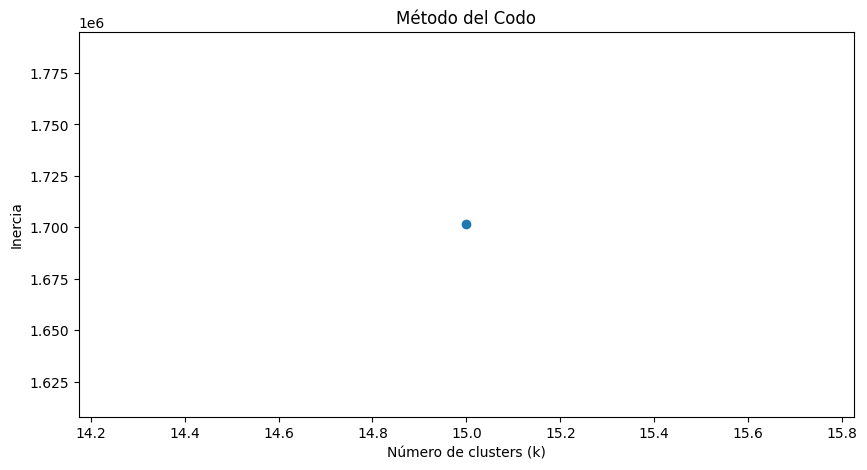

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

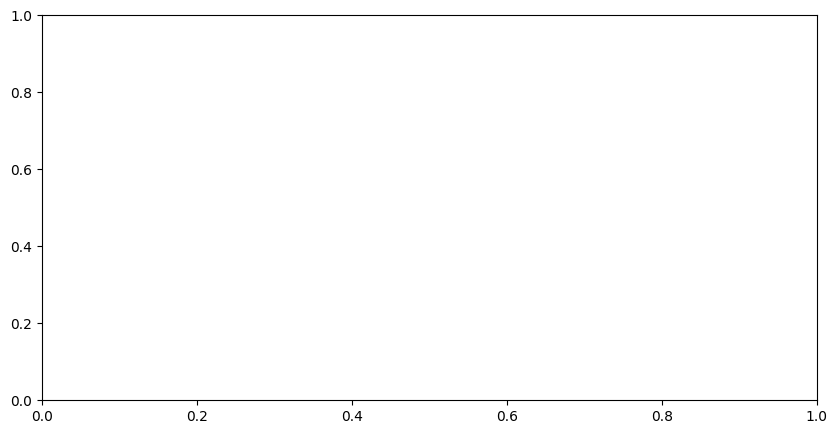

In [38]:
# Graficar el método del codo
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia[0:19], marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

#Graficar el Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.show()

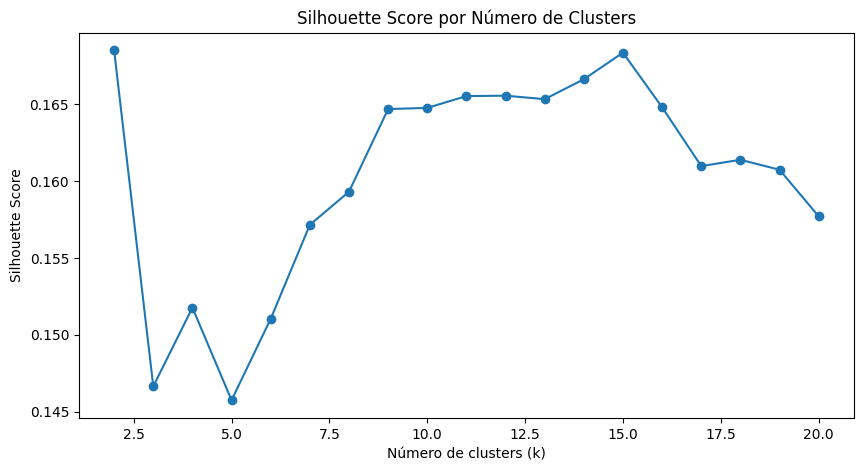

In [52]:
#Graficar el Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.show()

In [46]:
#Mostrar el mejor número de clusters
best_k = k_values[np.argmax(silhouette_scores)]
print(f"El mejor número de clusters basado en el Silhouette Score es: {best_k}")

El mejor número de clusters basado en el Silhouette Score es: 2


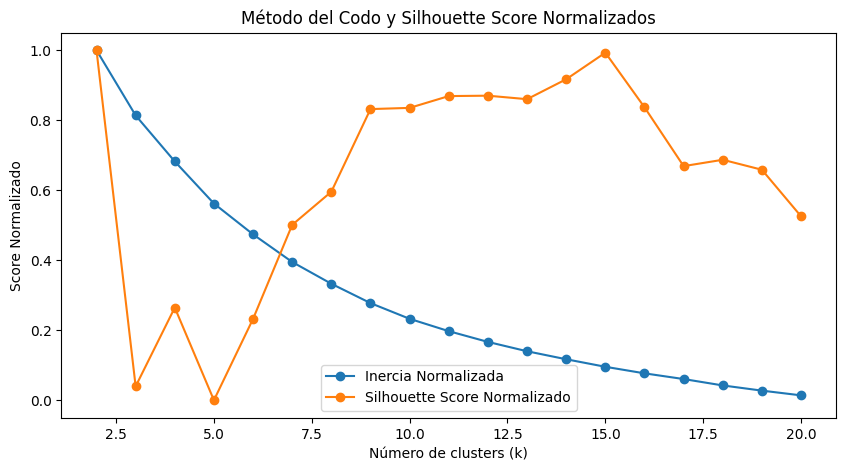

In [61]:
# Normalizar los valores de inercia y Silhouette Score
inertia_normalized = (inertia - np.min(inertia)) / (np.max(inertia) - np.min(inertia))
silhouette_scores_normalized = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))

plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_normalized[:len(k_values)], marker='o', label='Inercia Normalizada')
plt.plot(k_values, silhouette_scores_normalized, marker='o', label='Silhouette Score Normalizado')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Score Normalizado')
plt.title('Método del Codo y Silhouette Score Normalizados')
plt.legend()
plt.show()

# 6.2 Asignar los clusters a la base

Aqui probare distintas clusterizaciones

In [40]:
selected_columns = ['Probabilidad_No_Pago']

data_filtered_by_columns = df_informacion_clientes_clusterizar[selected_columns]

# Normalización de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered_by_columns)

# Reducción de dimensionalidad (opcional)
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_reduced = pca.fit_transform(data_scaled)

# Fit the KMeans model to the data
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(data_reduced)

# Predict the clusters
clusters = kmeans.predict(data_reduced)

# Assign the predicted clusters to the dataframe
df_informacion_clientes_clusterizar['Cluster'] = clusters

# Display the dataframe with the assigned clusters
df_informacion_clientes_clusterizar.head()

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,cantidad simulaciones,cantidad de ventas,tasa de concresion,Cluster
0,1,1,0,3,1,0.997340,0.028445,30.0,6.258183e+05,15,5,0.333333,0
1,2,0,0,1,1,0.291601,0.014320,41.0,3.172616e+05,10,2,0.200000,4
2,3,0,0,1,1,0.685085,0.002156,38.0,1.240551e+07,20,4,0.200000,1
3,4,1,0,3,1,0.914672,0.034418,57.0,5.441466e+05,25,9,0.360000,2
4,5,1,1,2,1,0.425077,0.014978,26.0,1.870225e+05,17,6,0.352941,4


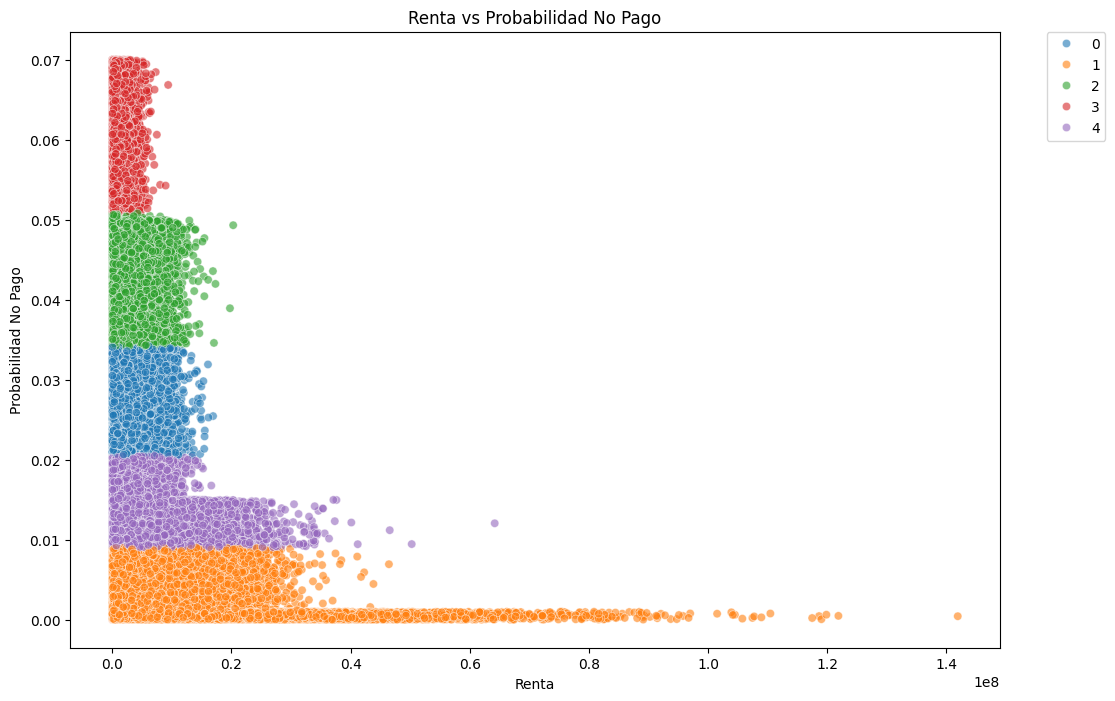

In [41]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=df_informacion_clientes_clusterizar,
    x='Renta',
    y='Probabilidad_No_Pago',
    hue='Cluster',
    palette='tab10',  # Use a palette that is less confusing
    alpha=0.6
)

# Set plot title and labels
scatter_plot.set_title('Renta vs Probabilidad No Pago')
scatter_plot.set_xlabel('Renta')
scatter_plot.set_ylabel('Probabilidad No Pago')

# Show the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Después de varias pruebas no es evidente una separación

# 6.5 Outliers

In [42]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Crear el modelo de Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Ajustar el modelo a los datos escalados
iso_forest.fit(data_filtered_by_columns)

# Predecir los outliers
outliers = iso_forest.predict(data_filtered_by_columns)

# Convertir las predicciones a un array booleano (True para outliers, False para inliers)
outliers_bool = outliers == -1

# Contar el número de outliers
num_outliers = np.sum(outliers_bool)
print(f"Número de outliers detectados: {num_outliers}")

# Filtrar los datos para eliminar los outliers
data_filtered_by_columns_no_outliers = data_filtered_by_columns[~outliers_bool]

# Mostrar la forma de los datos antes y después de eliminar los outliers
print(f"Forma de los datos originales: {data_filtered_by_columns.shape}")
print(f"Forma de los datos sin outliers: {data_filtered_by_columns_no_outliers.shape}")

KeyboardInterrupt: 

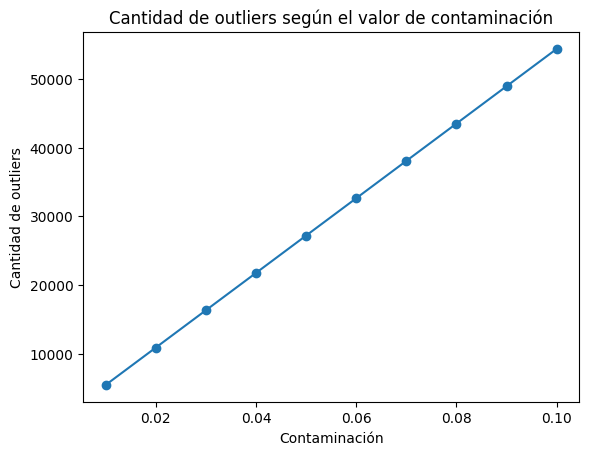

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Probar varios valores de contaminación
contamination_values = np.linspace(0.01, 0.1, 10)
outliers_count = []

for contamination in contamination_values:
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest.fit(data_scaled)
    outliers_pred = iso_forest.predict(data_scaled)
    
    # Contar la cantidad de outliers
    num_outliers = np.sum(outliers_pred == -1)
    outliers_count.append(num_outliers)

# Graficar la cantidad de outliers encontrados
plt.plot(contamination_values, outliers_count, marker='o')
plt.xlabel('Contaminación')
plt.ylabel('Cantidad de outliers')
plt.title('Cantidad de outliers según el valor de contaminación')
plt.show()


In [70]:
import numpy as np
import pandas as pd

# Umbral para el Z-score (típicamente 3)
threshold = 3

# Calcular el Z-score para cada valor en el DataFrame
z_scores = np.abs((data_filtered_by_columns - data_filtered_by_columns.mean()) / data_filtered_by_columns.std())

# Identificar outliers: donde el Z-score es mayor que el umbral
outliers = (z_scores > threshold)

# Filtrar los outliers
data_filtered_by_columns_outliers_data = data_filtered_by_columns[outliers.any(axis=1)]  # Filtrar filas que tienen al menos un outlier
data_filtered_by_columns_clean_data = data_filtered_by_columns[~outliers.any(axis=1)]    # Filtrar las filas que no tienen outliers

# Resultados
print(f"Cantidad de outliers identificados: {data_filtered_by_columns_outliers_data.shape[0]}")


Cantidad de outliers identificados: 17179


In [71]:
import pandas as pd



# Calcular los cuartiles
Q1 = data_filtered_by_columns.quantile(0.25)
Q3 = data_filtered_by_columns.quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers (valores fuera de los límites)
outliers = ((data_filtered_by_columns < lower_bound) | (data_filtered_by_columns > upper_bound))

# Filtrar los outliers
data_filtered_by_columns_outliers_data = data_filtered_by_columns[outliers.any(axis=1)]  # Filtrar filas que tienen al menos un outlier
data_filtered_by_columns_clean_data = data_filtered_by_columns[~outliers.any(axis=1)]    # Filtrar las filas que no tienen outliers

# Resultados
print(f"Cantidad de outliers identificados: {data_filtered_by_columns_outliers_data.shape[0]}")


Cantidad de outliers identificados: 62029


# 7 Clustering por politicas

In [ ]:
# df_simulaciones_e_informacion_de_clientes_ventas['venta'] = df_simulaciones_e_informacion_de_clientes_ventas['Unnamed: 0'].notna().astype(int)
# df_simulaciones_e_informacion_de_clientes_ventas.drop(columns=['Unnamed: 0'], inplace=True)

In [43]:
df_informacion_de_clientes_clusters = df_informacion_de_clientes.copy()

## 7.1 política de renta

Para la renta se tomarán dos supuestos. El de pareto de que el 80% de los clientes es financiado por el 20% y que existe un 30% de clientes complicados. En terminos de renta nos permite separarlos por los quintiles 80  y 30

In [44]:
# Calculate the 30th and 80th percentiles
percentil_30_renta = df_informacion_de_clientes['Renta'].quantile(0.20)
percentil_80_renta = df_informacion_de_clientes['Renta'].quantile(0.80)

# Define the new column based on the conditions
df_informacion_de_clientes_clusters['Separacion de renta'] = pd.cut(
    df_informacion_de_clientes_clusters['Renta'],
    bins=[-np.inf, percentil_30_renta, percentil_80_renta, np.inf],
    labels=['Renta baja', 'Renta media', 'Renta alta']
)

## 7.2 Política de probabilidad no pago

Esto es un codigo para encontrar los cortes de probabilidad de pago basado en el grafico renta vs prob no pago

In [45]:
max_probabilidad_no_pago_list = []

for renta_threshold in np.arange(0.00e+08, 0.95e+08, 0.001e+08):
    max_probabilidad_no_pago = df_informacion_de_clientes[df_informacion_de_clientes['Renta'] >= renta_threshold]['Probabilidad_No_Pago'].max()
    max_probabilidad_no_pago_list.append(max_probabilidad_no_pago)

In [96]:
data_filtered_by_columns

,Probabilidad_No_Pago,Probabilidad_No_Pago_Binned
0,0.028445,"(0.0283, 0.0285]"
1,0.014320,"(0.0142, 0.0143]"
2,0.002156,"(0.0021, 0.00227]"
3,0.034418,"(0.0343, 0.0345]"
4,0.014978,"(0.0149, 0.015]"
...,...,...
543646,0.037291,"(0.0373, 0.0374]"
543647,0.035877,"(0.0359, 0.036]"
543648,0.023306,"(0.0233, 0.0234]"
543649,0.015121,"(0.015, 0.0152]"


In [114]:
# Define the range
lower_bound = 0
upper_bound = data_filtered_by_columns['Probabilidad_No_Pago'].max() / 200
print(f"Upper bound: {upper_bound}")

# Filter the DataFrame for the specified range
filtered_df = data_filtered_by_columns[(data_filtered_by_columns['Probabilidad_No_Pago'] >= lower_bound) & 
                                       (data_filtered_by_columns['Probabilidad_No_Pago'] <= upper_bound)]

frecuency_list = []

for i in range (0, 401):
    filtered_df = data_filtered_by_columns[(data_filtered_by_columns['Probabilidad_No_Pago'] >= lower_bound) & 
                                       (data_filtered_by_columns['Probabilidad_No_Pago'] < upper_bound)]
    lower_bound += upper_bound
    upper_bound += upper_bound
    frequency = filtered_df.shape[0]
    if frequency == 0:
        break
    frecuency_list.append([frequency, upper_bound])

frecuency_list



Upper bound: 0.00034999514447841347


[[12236, 0.0006999902889568269],
 [12309, 0.0013999805779136539],
 [7217, 0.0027999611558273078],
 [7187, 0.0055999223116546155],
 [7095, 0.011199844623309231],
 [7206, 0.022399689246618462],
 [2183, 0.044799378493236924],
 [1264, 0.08959875698647385]]

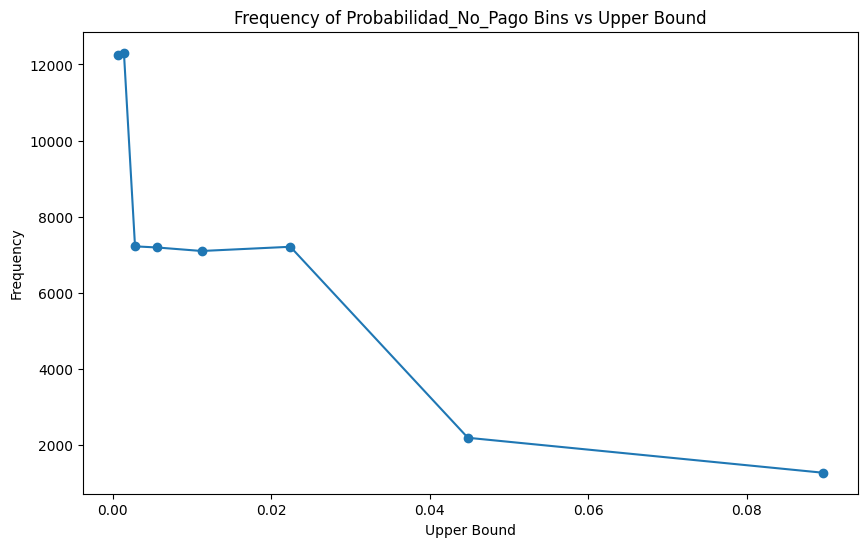

In [115]:
import matplotlib.pyplot as plt

# Extract the frequencies and upper bounds from the frequency list
frequencies = [item[0] for item in frecuency_list]
upper_bounds = [item[1] for item in frecuency_list]

# Plot the frequency vs upper bound
plt.figure(figsize=(10, 6))
plt.plot(upper_bounds, frequencies, marker='o')
plt.xlabel('Upper Bound')
plt.ylabel('Frequency')
plt.title('Frequency of Probabilidad_No_Pago Bins vs Upper Bound')
plt.show()

Se establecen los cortes de la probabilidad segun lo visto en el grafdico de arriba

In [70]:
#Se establecen los cortes de la probabilidad segun lo visto arriba
corte_prob_2 = 0.05
corte_prob_3 = 0.0151
corte_prob_4 = 0.001

# Define the new column based on the conditions
df_informacion_de_clientes_clusters['Separacion de probabilidad no pago'] = pd.cut(
    df_informacion_de_clientes_clusters['Probabilidad_No_Pago'],
    bins=[-np.inf, corte_prob_4, corte_prob_3, corte_prob_2, np.inf],
    labels=['Muy buen pagador', 'Buen pagador', 'Mal pagador', 'Muy mal pagador']
)

## 7.x Asignacion de los clusters por politica

In [72]:
df_informacion_de_clientes_clusters['Clusters caracteristicas'] = df_informacion_de_clientes_clusters['Separacion de renta'].astype(str) + ' - ' + df_informacion_de_clientes_clusters['Separacion de probabilidad no pago'].astype(str)
# Create a new column 'Clusters caracteristicas numerico' that assigns a unique number to each unique entry in 'Clusters caracteristicas'
df_informacion_de_clientes_clusters['Clusters caracteristicas numerico'] = df_informacion_de_clientes_clusters['Clusters caracteristicas'].astype('category').cat.codes


## 7.y Analisis de los cluster de politica

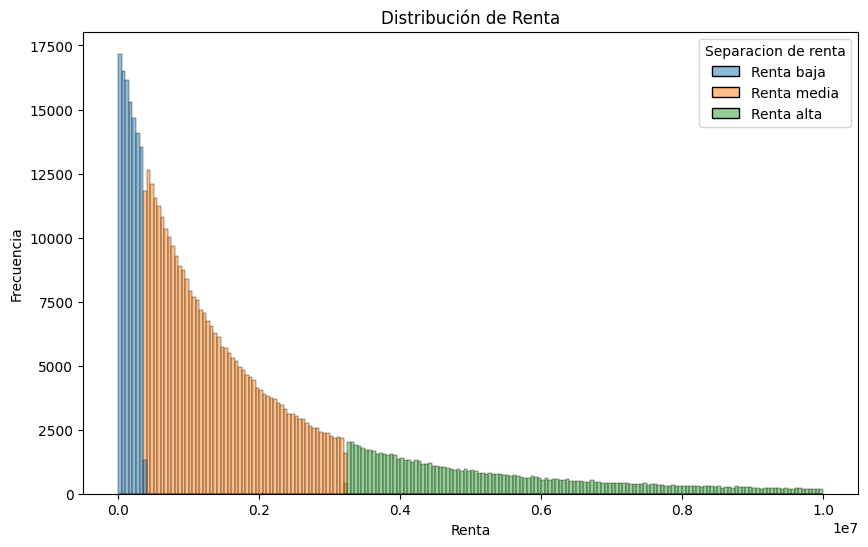

In [84]:
# Filter out rows where Renta is greater than or equal to 0.2e+08
df_filtered = df_informacion_de_clientes_clusters[df_informacion_de_clientes_clusters['Renta'] < 1e+07]

# Convert data to long-form
df_long = df_filtered[['Renta', 'Separacion de renta']].copy()

# Create a histogram plot for the 'Renta' column
plt.figure(figsize=(10, 6))
sns.histplot(data=df_long, x='Renta', bins=200, hue='Separacion de renta', palette='tab10')
plt.title('Distribución de Renta')
plt.xlabel('Renta')
plt.ylabel('Frecuencia')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


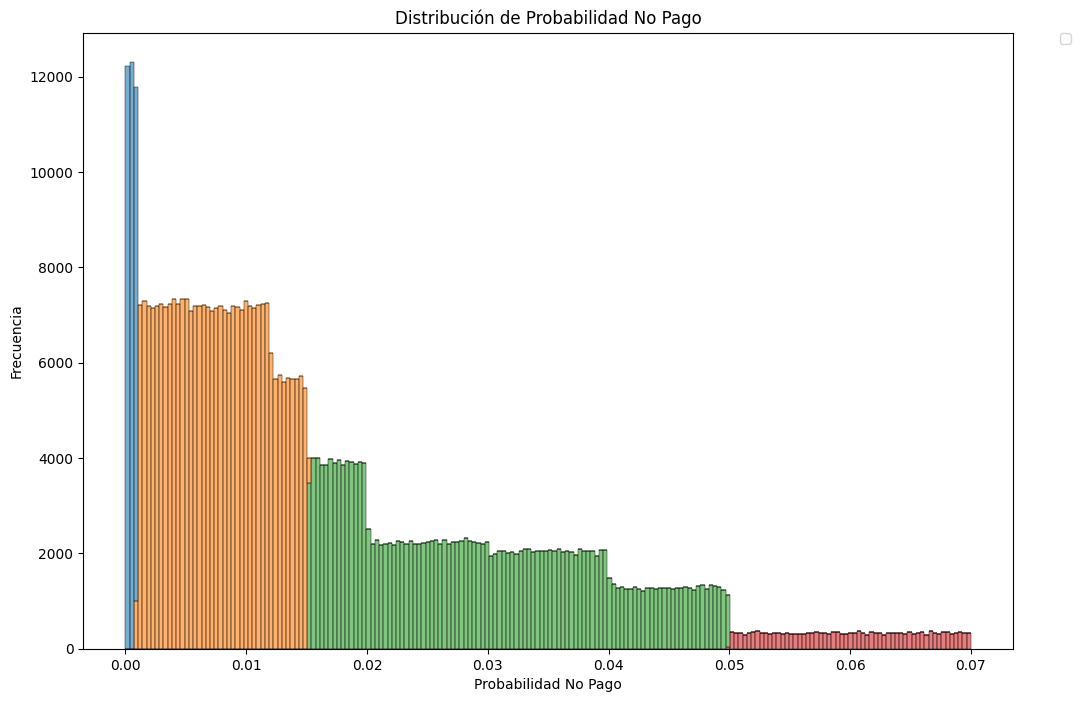

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the histogram plot
plt.figure(figsize=(12, 8))
hist_plot = sns.histplot(
    data=df_informacion_de_clientes_clusters,
    x='Probabilidad_No_Pago',
    hue='Separacion de probabilidad no pago',
    palette='tab10',  # Use a palette that is less confusing
    multiple='stack',  # Stack the histograms
    bins = 200,
    alpha=0.6
)

# Set plot title and labels
hist_plot.set_title('Distribución de Probabilidad No Pago')
hist_plot.set_xlabel('Probabilidad No Pago')
hist_plot.set_ylabel('Frecuencia')

# Show the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# 8 Graficos de tablas de Ilan

In [1]:
import os
import glob
import pandas as pd

# Define the folder path
folder_path = 'tablas de ilan'

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Dictionary to store dataframes
dataframes = {}

# Read each CSV file into a dataframe and store it in the dictionary
for file in csv_files:
    # Extract the file name without extension to use as the key
    file_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[file_name] = pd.read_csv(file)

# Display the keys of the dictionary to verify
print(dataframes.keys())

dict_keys(['Tabla_Digital', 'Tabla_Edad', 'Tabla_Elasticidad', 'Tabla_Genero', 'Tabla_Nacionalidad', 'Tabla_No_Pago', 'Tabla_Propension', 'Tabla_Renta'])


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_revenue_potencial(df_name):
    if df_name not in dataframes:
        raise ValueError(f"DataFrame '{df_name}' not found in dataframes dictionary.")
    
    df = dataframes[df_name]
    
    variables = ["N_Simulaciones","N_Ventas","Tasa_Curse","Tasa_Promedio","Monto_Promedio","Plazo_Promedio","Tasa_Prom","Revenue_Potencial"]
    # Create output directory if it doesn't exist
    
    for var in variables:
        # Create the plot
        plt.figure(figsize=(18, 8))
        scatter_plot = sns.scatterplot(
            data=df,
            x='Mes',
            y=var,
            hue='Tratamiento',
            style='Cluster',
            palette='tab10'
        )

        # Modify x-axis labels
        tick_locations = scatter_plot.get_xticks()
        tick_labels = [f'{int(tick)}' for tick in tick_locations]
        scatter_plot.set_xticklabels(tick_labels)  # Smaller font size

        output_dir = f'output_graficos_ilan_todos/{df_name}'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Set plot title and labels
        plt.title(f'{var} por Mes de {df_name}')
        plt.xlabel('Mes')
        plt.ylabel(f'{var}')

        # Adjust the number of ticks on x-axis (show every 2nd month)
        plt.xticks(fontsize=8)  # Smaller fontsize for ticks

        # Adjust the layout
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()  # Adjust the layout to avoid clipping

        # Save the plot as a PNG file in the specified directory
        output_path = os.path.join(output_dir, f'{df_name}_{var}.png')
        plt.savefig(output_path, format='png')

        # Close the plot to free memory
        plt.close()

# Example usage
plot_revenue_potencial('Tabla_Digital')



C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xtickl

In [50]:
import os

# Iterate through each dataframe in the dictionary and plot/save
for df_name in dataframes.keys():
    plot_revenue_potencial(df_name)


C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2910129572.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xtickl

## 8.2 Tablas de ilan 2

In [83]:
import os
import glob
import pandas as pd

# Define the folder path
folder_path = 'tablas de ilan 2'

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Dictionary to store dataframes
dataframes = {}

# Read each CSV file into a dataframe and store it in the dictionary
for file in csv_files:
    # Extract the file name without extension to use as the key
    file_name = os.path.splitext(os.path.basename(file))[0]
    dataframes[file_name] = pd.read_csv(file)

# Display the keys of the dictionary to verify
print(dataframes.keys())

dict_keys(['Tabla_Digital_2', 'Tabla_Edad_2', 'Tabla_Elasticidad_2', 'Tabla_Genero_2', 'Tabla_Nacionalidad_2', 'Tabla_No_Pago_2', 'Tabla_Propension_2', 'Tabla_Renta_2'])


In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_revenue_potencial(df_name):
    if df_name not in dataframes:
        raise ValueError(f"DataFrame '{df_name}' not found in dataframes dictionary.")
    
    df = dataframes[df_name]
    
    # variables = ["N_Simulaciones","N_Ventas","Tasa_Curse","Tasa_Promedio","Monto_Promedio","Plazo_Promedio","Tasa_Prom","Revenue_Potencial"]
    variables = ['N_Simulaciones',	'N_Ventas',	'Tasa_Curse',	'Tasa_Promedio',	'Monto_Promedio',	'Plazo_Promedio',	'Tasa_Promedio_Ventas',	'Monto_Promedio_Ventas',	'Plazo_Promedio_Ventas',	'Tasa_Prom',	'Tasa_Prom_Ventas',	'Revenue_Potencial',	'Revenue_Potencial_Ventas',	'Tasa_Revenue']
    # Create output directory if it doesn't exist
    
    for var in variables:
        # Create the plot
        plt.figure(figsize=(18, 8))
        scatter_plot = sns.scatterplot(
            data=df,
            x='Mes',
            y=var,
            hue='Tratamiento',
            style='Cluster',
            palette='tab10'
        )

        # Modify x-axis labels
        tick_locations = scatter_plot.get_xticks()
        tick_labels = [f'{int(tick)}' for tick in tick_locations]
        scatter_plot.set_xticklabels(tick_labels)  # Smaller font size

        output_dir = f'output_graficos_ilan_2/{df_name}'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Set plot title and labels
        plt.title(f'{var} por Mes de {df_name}')
        plt.xlabel('Mes')
        plt.ylabel(f'{var}')

        # Adjust the number of ticks on x-axis (show every 2nd month)
        plt.xticks(fontsize=8)  # Smaller fontsize for ticks

        # Adjust the layout
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()  # Adjust the layout to avoid clipping

        # Save the plot as a PNG file in the specified directory
        output_path = os.path.join(output_dir, f'{df_name}_{var}.png')
        plt.savefig(output_path, format='png')

        # Close the plot to free memory
        plt.close()

# Example usage
plot_revenue_potencial('Tabla_Digital_2')



C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xtickl

In [87]:
import os

# Iterate through each dataframe in the dictionary and plot/save
for df_name in dataframes.keys():
    plot_revenue_potencial(df_name)


C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xticklabels(tick_labels)  # Smaller font size
C:\Users\7coto\AppData\Local\Temp\ipykernel_19900\2314356098.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  scatter_plot.set_xtickl

# 9 Gráficos varios

In [44]:
df_simulaciones_e_informacion_de_clientes_ventas['venta'].fillna(0, inplace=True)

In [46]:
df_simulaciones_e_informacion_de_clientes_ventas

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,fecha,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo,venta
0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2019-10-01,319936.0,33.0,1.092295,1,0
1,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2019-11-01,249773.0,30.0,2.324675,1,0
2,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2020-02-01,280087.0,28.0,1.051704,1,1
3,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2021-05-01,289780.0,26.0,2.193118,1,0
4,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2021-06-01,258061.0,22.0,2.188368,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517080,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-03-01,403331.0,17.0,2.356028,1,0
8517081,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-08-01,359897.0,16.0,2.478376,1,0
8517082,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-03-01,348048.0,18.0,2.301079,1,0
8517083,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-05-01,344504.0,16.0,2.462272,1,1


In [75]:
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,...,Plazo_Simulado,Tasa_Simulado,simulo,venta,Unnamed: 0_y,n_correos,asg_ejec,mes,Mes,Tratamiento
0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,33.0,1.092295,1,0,0.0,2.0,0.0,2019-10,2019-10,"Ejecutivo=0.0, Correos=2.0"
1,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,30.0,2.324675,1,0,0.0,0.0,0.0,2019-11,2019-11,"Ejecutivo=0.0, Correos=0.0"
2,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,28.0,1.051704,1,1,0.0,1.0,0.0,2020-02,2020-02,"Ejecutivo=0.0, Correos=1.0"
3,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,26.0,2.193118,1,0,0.0,1.0,0.0,2021-05,2021-05,"Ejecutivo=0.0, Correos=1.0"
4,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,22.0,2.188368,1,1,0.0,3.0,0.0,2021-06,2021-06,"Ejecutivo=0.0, Correos=3.0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517080,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,...,17.0,2.356028,1,0,543650.0,2.0,1.0,2023-03,2023-03,"Ejecutivo=1.0, Correos=2.0"
8517081,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,...,16.0,2.478376,1,0,543650.0,2.0,0.0,2023-08,2023-08,"Ejecutivo=0.0, Correos=2.0"
8517082,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,...,18.0,2.301079,1,0,543650.0,4.0,0.0,2024-03,2024-03,"Ejecutivo=0.0, Correos=4.0"
8517083,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,...,16.0,2.462272,1,1,543650.0,0.0,1.0,2024-05,2024-05,"Ejecutivo=1.0, Correos=0.0"


In [78]:
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['n_correos'].isna().sum()

747

In [72]:
# Use vectorized string operations to create the 'Tratamiento' column
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['Tratamiento'] = (
    'Ejecutivo=' + df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['asg_ejec'].astype(str) +
    ', Correos=' + df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['n_correos'].astype(int).astype(str)
)

df_simulaciones_e_informacion_de_clientes_ventas_tratamiento

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [68]:
cluster = 'Categoria_Digital'

# Ensure the 'fecha' column is in datetime format
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['fecha'] = pd.to_datetime(df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['fecha'])

# Extract the month from the 'fecha' column
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['Mes'] = df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['fecha'].dt.to_period('M')

# Group by 'Cluster', 'Mes', and 'Tratamiento' and calculate the required metrics
grouped_df = df_simulaciones_e_informacion_de_clientes_ventas_tratamiento.groupby([cluster, 'Mes', 'Tratamiento']).agg(
    N_Simulaciones=('Monto_Simulado', 'count'),
    N_Ventas=('venta', 'sum'),
    Tasa_Curse=('venta', lambda x: x.sum() / x.count() if x.count() > 0 else 0),
    Tasa_Promedio=('Tasa_Simulado', 'mean'),
    Monto_Promedio=('Monto_Simulado', 'mean'),
    Plazo_Promedio=('Plazo_Simulado', 'mean'),
    Tasa_Prom=('Tasa_Simulado', 'mean'),
    Revenue_Potencial=('Monto_Simulado', 'sum')
).reset_index()

# Save the resulting dataframe to a CSV file
grouped_df

KeyError: 'Tratamiento'

In [65]:
# Group by 'rut' and calculate the required aggregations
df_grouped = df_simulaciones_e_informacion_de_clientes_ventas.groupby('rut').agg(
    Elasticidad_Precios=('Elasticidad_Precios', 'first'),  # Assuming you want the first value
    Monto_Simulado_Mean=('Monto_Simulado', 'mean'),
    Plazo_Simulado_Mean=('Plazo_Simulado', 'mean'),
    Tasa_Simulado_Mean=('Tasa_Simulado', 'mean'),
    Simulo_Count=('simulo', 'count'),
    Venta_Count=('venta', 'sum')  # Assuming 'venta' is binary (0 or 1)
).reset_index()

df_grouped

,rut,Elasticidad_Precios,Monto_Simulado_Mean,Plazo_Simulado_Mean,Tasa_Simulado_Mean,Simulo_Count,Venta_Count
0,1,Alta,2.685672e+05,30.400000,1.776668,15,5
1,2,Baja,8.333564e+05,22.300000,1.877649,10,2
2,3,Baja,3.167542e+07,28.800000,1.831918,20,4
3,4,Alta,1.401495e+06,20.720000,1.849053,25,9
4,5,Media,4.879516e+05,35.235294,1.772920,17,6
...,...,...,...,...,...,...,...
543646,543647,Baja,8.371279e+05,30.375000,1.913178,8,0
543647,543648,Baja,7.404169e+06,18.444444,1.734614,18,3
543648,543649,Media,1.919464e+06,19.000000,1.842565,14,8
543649,543650,Media,4.353412e+06,18.909091,1.614806,22,12


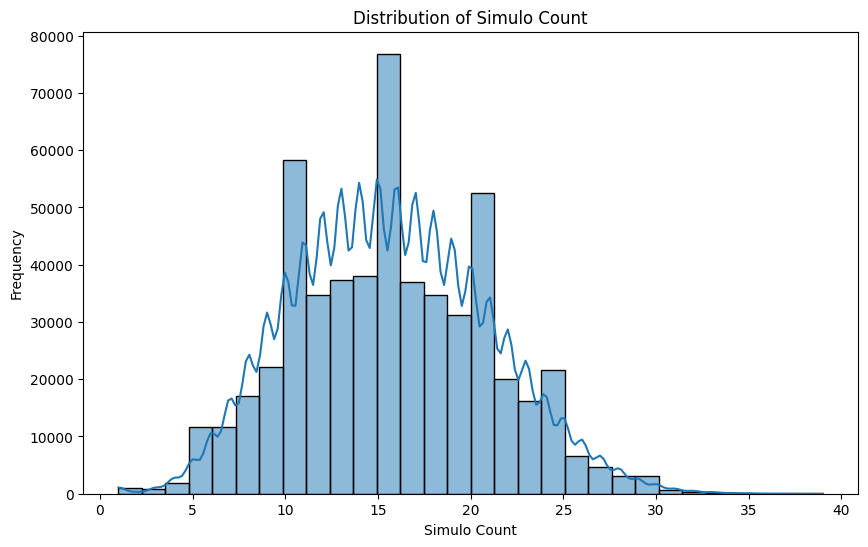

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the histogram plot
plt.figure(figsize=(10, 6))
hist_plot = sns.histplot(
    data=df_grouped,
    x='Simulo_Count',
    bins=30,  # You can adjust the number of bins as needed
    kde=True  # Add a kernel density estimate
)

# Set plot title and labels
hist_plot.set_title('Distribution of Simulo Count')
hist_plot.set_xlabel('Simulo Count')
hist_plot.set_ylabel('Frequency')

# Show the plot
plt.show()


In [58]:
df_grouped

,rut,Monto_Simulado_Mean,Plazo_Simulado_Mean,Tasa_Simulado_Mean,Simulo_Count,Venta_Count
0,1,2.685672e+05,30.400000,1.776668,15,5
1,2,8.333564e+05,22.300000,1.877649,10,2
2,3,3.167542e+07,28.800000,1.831918,20,4
3,4,1.401495e+06,20.720000,1.849053,25,9
4,5,4.879516e+05,35.235294,1.772920,17,6
...,...,...,...,...,...,...
543646,543647,8.371279e+05,30.375000,1.913178,8,0
543647,543648,7.404169e+06,18.444444,1.734614,18,3
543648,543649,1.919464e+06,19.000000,1.842565,14,8
543649,543650,4.353412e+06,18.909091,1.614806,22,12


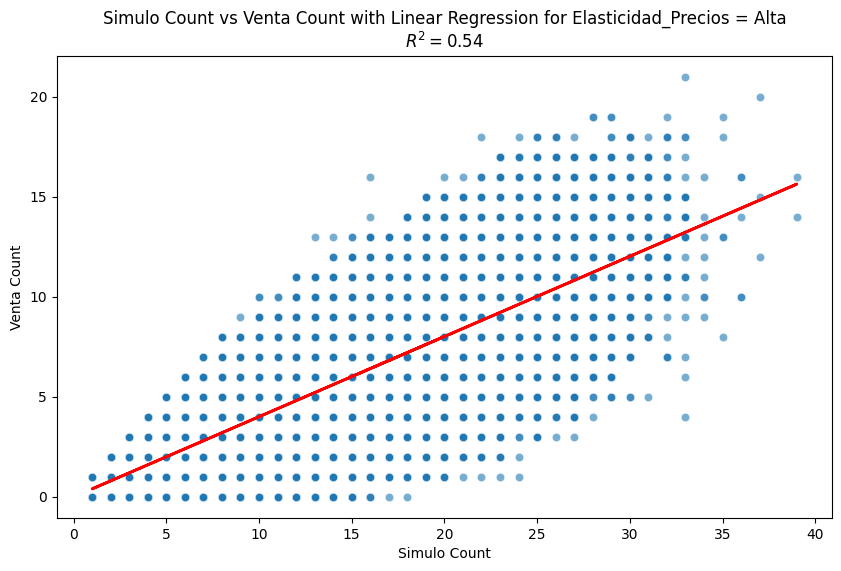

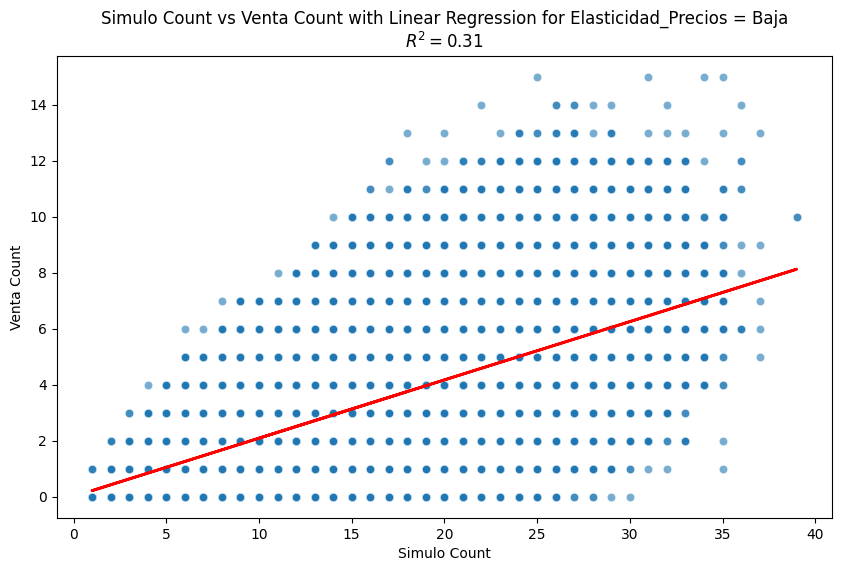

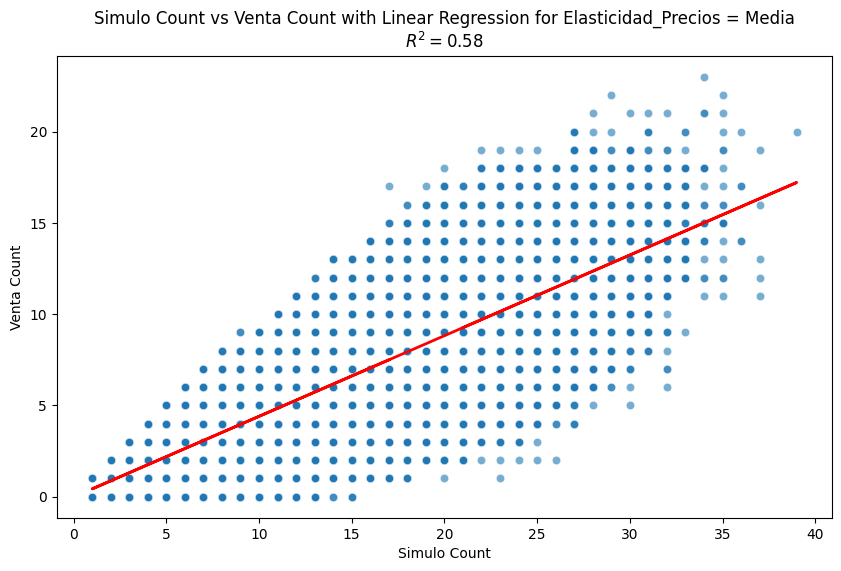

In [63]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique values of Elasticidad_Precios
unique_elasticidades = df_grouped['Elasticidad_Precios'].unique()

# Loop through each unique value of Elasticidad_Precios
for elasticidad in unique_elasticidades:
    # Filter the dataframe for the current Elasticidad_Precios
    df_filtered = df_grouped[df_grouped['Elasticidad_Precios'] == elasticidad]
    
    # Prepare the data
    X = df_filtered['Simulo_Count'].values.reshape(-1, 1)
    y = df_filtered['Venta_Count'].values
    
    # Create and fit the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate R-squared
    r_squared = model.score(X, y)
    
    # Plot the data and the regression line
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(
        data=df_filtered,
        x='Simulo_Count',
        y='Venta_Count',
        alpha=0.6
    )
    
    # Plot the regression line
    plt.plot(df_filtered['Simulo_Count'], y_pred, color='red', linewidth=2)
    
    # Set plot title and labels
    scatter_plot.set_title(f'Simulo Count vs Venta Count with Linear Regression for Elasticidad_Precios = {elasticidad}\n$R^2 = {r_squared:.2f}$')
    scatter_plot.set_xlabel('Simulo Count')
    scatter_plot.set_ylabel('Venta Count')
    
    # Show the plot
    plt.show()

# 10. CLUSTERING DEFINITIVO POR POLITICAS

In [129]:
df_informacion_de_clientes_procesados_cluster_definitivo = df_informacion_de_clientes[['rut', 'Categoria_Digital', 'Edad', 'Genero', 'Renta', 'Propension', 'Probabilidad_No_Pago']].copy()


In [130]:
import pandas as pd

# Create a copy of the dataframe to work with
df = df_informacion_de_clientes_procesados_cluster_definitivo.copy()

# Propensión
df['Categoria_Propenso'] = pd.qcut(df['Propension'], 3, labels=['Propension baja', 'Propension media', 'Propension alta'])

# Probabilidad_No_Pago
df['Categoria_Probabilidad_No_Pago'] = pd.cut(df['Probabilidad_No_Pago'], 
                                              bins=[-float('inf'), 0.0011, 0.00149, 0.005, 0.006, float('inf')],
                                              labels=['Muy buen pagador', 'Buen pagador', 'Pagador neutro', 'Mal pagador', 'Muy mal pagador'])

# Edad
df['Categoria_Edad'] = pd.cut(df['Edad'], 
                              bins=[-float('inf'), 35, 60, float('inf')],
                              labels=['Joven', 'Adulto', 'Adulto Mayor'])

# Renta
df_unicos_renta = df[['rut', 'Renta']].drop_duplicates()
df_unicos_renta['Percentil_Renta'] = pd.qcut(df_unicos_renta['Renta'], 100, labels=False) + 1
df_unicos_renta['Categoria_Renta'] = pd.cut(df_unicos_renta['Percentil_Renta'], 
                                            bins=[-float('inf'), 30, 80, float('inf')],
                                            labels=['Renta Baja', 'Renta Media', 'Renta Alta'])

# Merge the renta categories back to the main dataframe
df = df.merge(df_unicos_renta[['rut', 'Categoria_Renta']], on='rut', how='left')

# Display the dataframe with the new columns
df

,rut,Categoria_Digital,Edad,Genero,Renta,Propension,Probabilidad_No_Pago,Categoria_Propenso,Categoria_Probabilidad_No_Pago,Categoria_Edad,Categoria_Renta
0,1,Cliente no Digital,30.0,Masculino,6.258183e+05,0.997340,0.028445,Propension alta,Muy mal pagador,Joven,Renta Media
1,2,Cliente no Digital,41.0,Femenino,3.172616e+05,0.291601,0.014320,Propension baja,Muy mal pagador,Adulto,Renta Baja
2,3,Cliente no Digital,38.0,Femenino,1.240551e+07,0.685085,0.002156,Propension alta,Pagador neutro,Adulto,Renta Alta
3,4,Cliente no Digital,57.0,Masculino,5.441466e+05,0.914672,0.034418,Propension alta,Muy mal pagador,Adulto,Renta Baja
4,5,Cliente Digital,26.0,Masculino,1.870225e+05,0.425077,0.014978,Propension media,Muy mal pagador,Joven,Renta Baja
...,...,...,...,...,...,...,...,...,...,...,...
543646,543647,Cliente Digital,29.0,Femenino,1.176598e+05,0.144657,0.037291,Propension baja,Muy mal pagador,Joven,Renta Baja
543647,543648,Cliente no Digital,31.0,Masculino,1.558612e+06,0.740170,0.035877,Propension alta,Muy mal pagador,Joven,Renta Media
543648,543649,Cliente no Digital,49.0,Masculino,9.449508e+05,0.255285,0.023306,Propension baja,Muy mal pagador,Adulto,Renta Media
543649,543650,Cliente no Digital,40.0,Femenino,1.039964e+06,0.709086,0.015121,Propension alta,Muy mal pagador,Adulto,Renta Media


In [131]:
# Check for NaN values in the DataFrame
nan_summary = df.isnull().any()

# Print the summary
print(nan_summary)

rut                               False
Categoria_Digital                 False
Edad                              False
Genero                            False
Renta                             False
Propension                        False
Probabilidad_No_Pago              False
Categoria_Propenso                False
Categoria_Probabilidad_No_Pago    False
Categoria_Edad                    False
Categoria_Renta                   False
dtype: bool


In [132]:
# Concatenate the specified variables into a new column
df['categoria_clusterizacion'] = (
    df['Categoria_Digital'].astype(str) + ' ' +
    df['Categoria_Edad'].astype(str) + ' de genero ' +
    df['Genero'].astype(str) + ' con ' +
    df['Categoria_Propenso'].astype(str) + ' con una ' +
    df['Categoria_Renta'].astype(str)
)

# Display the dataframe with the new column
df.head()

,rut,Categoria_Digital,Edad,Genero,Renta,Propension,Probabilidad_No_Pago,Categoria_Propenso,Categoria_Probabilidad_No_Pago,Categoria_Edad,Categoria_Renta,categoria_clusterizacion
0,1,Cliente no Digital,30.0,Masculino,6.258183e+05,0.997340,0.028445,Propension alta,Muy mal pagador,Joven,Renta Media,Cliente no Digital Joven de genero Masculino c...
1,2,Cliente no Digital,41.0,Femenino,3.172616e+05,0.291601,0.014320,Propension baja,Muy mal pagador,Adulto,Renta Baja,Cliente no Digital Adulto de genero Femenino c...
2,3,Cliente no Digital,38.0,Femenino,1.240551e+07,0.685085,0.002156,Propension alta,Pagador neutro,Adulto,Renta Alta,Cliente no Digital Adulto de genero Femenino c...
3,4,Cliente no Digital,57.0,Masculino,5.441466e+05,0.914672,0.034418,Propension alta,Muy mal pagador,Adulto,Renta Baja,Cliente no Digital Adulto de genero Masculino ...
4,5,Cliente Digital,26.0,Masculino,1.870225e+05,0.425077,0.014978,Propension media,Muy mal pagador,Joven,Renta Baja,Cliente Digital Joven de genero Masculino con ...


In [133]:
# Assign a unique number to each unique entry in 'categoria_clusterizacion'
df['categoria_clusterizacion_numerica'] = df['categoria_clusterizacion'].astype('category').cat.codes

# Display the dataframe with the new column
df.head()

,rut,Categoria_Digital,Edad,Genero,Renta,Propension,Probabilidad_No_Pago,Categoria_Propenso,Categoria_Probabilidad_No_Pago,Categoria_Edad,Categoria_Renta,categoria_clusterizacion,categoria_clusterizacion_numerica
0,1,Cliente no Digital,30.0,Masculino,6.258183e+05,0.997340,0.028445,Propension alta,Muy mal pagador,Joven,Renta Media,Cliente no Digital Joven de genero Masculino c...,101
1,2,Cliente no Digital,41.0,Femenino,3.172616e+05,0.291601,0.014320,Propension baja,Muy mal pagador,Adulto,Renta Baja,Cliente no Digital Adulto de genero Femenino c...,76
2,3,Cliente no Digital,38.0,Femenino,1.240551e+07,0.685085,0.002156,Propension alta,Pagador neutro,Adulto,Renta Alta,Cliente no Digital Adulto de genero Femenino c...,72
3,4,Cliente no Digital,57.0,Masculino,5.441466e+05,0.914672,0.034418,Propension alta,Muy mal pagador,Adulto,Renta Baja,Cliente no Digital Adulto de genero Masculino ...,82
4,5,Cliente Digital,26.0,Masculino,1.870225e+05,0.425077,0.014978,Propension media,Muy mal pagador,Joven,Renta Baja,Cliente Digital Joven de genero Masculino con ...,52


In [134]:
unique_count = df['categoria_clusterizacion_numerica'].nunique()
print(f"Number of unique values in 'categoria_clusterizacion_numerica': {unique_count}")

Number of unique values in 'categoria_clusterizacion_numerica': 108


In [135]:
asignacion_clusters = df[['rut', 'categoria_clusterizacion', 'categoria_clusterizacion_numerica']].copy()

In [103]:
asignacion_clusters.to_csv('asignacion_clusters.csv', index=False)

C:\Users\7coto\AppData\Local\Temp\ipykernel_11980\1949779085.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


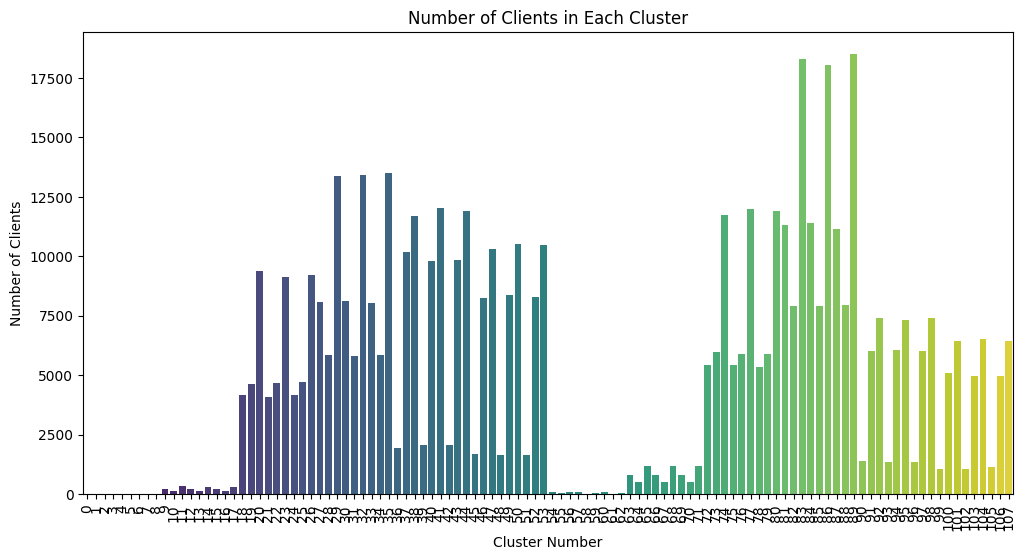

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of clients in each cluster
cluster_counts = df['categoria_clusterizacion_numerica'].value_counts()

# Plot the number of clients in each cluster
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Clients')
plt.title('Number of Clients in Each Cluster')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

## 10.2 Estimacion de curvas de elasticidad por cluster

In [137]:
df_estimar_elasticidad = pd.merge(df_simulaciones_e_informacion_de_clientes_ventas, asignacion_clusters, on='rut', how='left')

In [107]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Create the output directory if it doesn't exist
output_dir = 'estimacion-elasticidad'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each cluster from 1 to 108 (currently just cluster 1 for this example)
for cluster_num in range(0, 108):
    # Filter the dataframe for the current cluster and where 'venta' is 1
    df_cluster_ventas = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 1)]
    
    if df_cluster_ventas.empty:
        continue
    
    # Get the cluster description
    cluster_description = df_cluster_ventas['categoria_clusterizacion'].iloc[0]
    
    # Create the histogram plot for 'Tasa_Simulado'
    plt.figure(figsize=(10, 6))
    hist_plot = sns.histplot(
        data=df_cluster_ventas,
        x='Tasa_Simulado',
        bins=60,  # You can adjust the number of bins as needed
        kde=True  # Add a kernel density estimate
    )

    # Set plot title and labels
    hist_plot.set_title(f'Distribution of Tasa_Simulado for Cluster {cluster_num} (Ventas = 1)\n Descripcion de cluster: {cluster_description}')
    hist_plot.set_xlabel('Tasa_Simulado')
    hist_plot.set_ylabel('Frequency')

    # Add cluster description text to the plot
    # Adjust the position of the text
    # plt.text(
    #     0.95, 0.95,  # X and Y positions in axes coordinates (adjusted to fit inside plot)
    #     f'Description: {cluster_description}',  # Add a prefix for clarity
    #     transform=plt.gca().transAxes,  # Position relative to axes
    #     fontsize=12,  # Font size
    #     verticalalignment='top',  # Align text at the top
    #     horizontalalignment='right',  # Align to the right for better positioning
    #     bbox=dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round,pad=0.5')  # Use a box around text
    # )

    # Extract KDE data
    kde_data = hist_plot.lines[0].get_data()
    kde_df = pd.DataFrame({'Tasa_Simulado': kde_data[0], 'Density': kde_data[1]})

    # # Save KDE data to a CSV file
    # kde_df.to_csv(os.path.join(output_dir, f'kde_estimation_cluster_{cluster_num}_ventas.csv'), index=False)

    # Save the plot as a PNG file
    plt.savefig(os.path.join(output_dir, f'cluster_{cluster_num}_estimacion.png'))

    # Close the plot to free memory
    plt.close()


In [134]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Create the output directory if it doesn't exist
output_dir = 'estimacion-elasticidad-v1-v0'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each cluster from 1 to 108
for cluster_num in range(0, 108):
    # Filter the dataframe for the current cluster and where 'venta' is 1
    df_cluster_ventas_1 = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 1)]
    df_cluster_ventas_0 = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 0)]
    
    if df_cluster_ventas_1.empty and df_cluster_ventas_0.empty:
        continue

    # Get the cluster description
    if not df_cluster_ventas_1.empty:
        cluster_description = df_cluster_ventas_1['categoria_clusterizacion'].iloc[0]
    else:
        cluster_description = df_cluster_ventas_0['categoria_clusterizacion'].iloc[0]

    # Create the histogram plot for 'Tasa_Simulado' (Ventas = 1)
    plt.figure(figsize=(10, 6))
    
    # Plot for ventas = 1 (default blue color)
    if not df_cluster_ventas_1.empty:
        hist_plot_1 = sns.histplot(
            data=df_cluster_ventas_1,
            x='Tasa_Simulado',
            bins=60,
            kde=True,
            label="Ventas = 1"  # Add label for legend
        )

    # Plot for ventas = 0 (red color with reduced opacity)
    if not df_cluster_ventas_0.empty:
        hist_plot_0 = sns.histplot(
            data=df_cluster_ventas_0,
            x='Tasa_Simulado',
            bins=60,
            kde=True,
            color="red",  # Make the KDE line red
            line_kws={'alpha': 0.5},  # Reduce opacity for the KDE line
            label="Ventas = 0"  # Add label for legend
        )
    
    # Set plot title and labels
    plt.title(f'Distribution of Tasa_Simulado for Cluster {cluster_num}\n Descripción de cluster: {cluster_description}')
    plt.xlabel('Tasa_Simulado')
    plt.ylabel('Frequency')
    
    # Add a legend to differentiate between ventas = 1 and ventas = 0
    plt.legend()

    # Save the plot as a PNG file
    plt.savefig(os.path.join(output_dir, f'cluster_{cluster_num}_estimacion_ventas_comparison.png'))

    # Close the plot to free memory
    plt.close()


Este código tiene como objetivo calcular el **precio que maximiza la probabilidad de aceptación** de un crédito para cada cluster de clientes. La probabilidad de aceptación se basa en la **estimación de densidad kernel (KDE)** de la tasa simulada (`Tasa_Simulado`), que representa la demanda para `ventas = 1` (clientes que aceptan el crédito). Primero, se calcula la **densidad** para cada precio en un cluster específico. Luego, se normaliza la densidad dividiendo cada valor de densidad por la suma total de todas las densidades, lo que da como resultado una **probabilidad** entre 0 y 1. Esta probabilidad refleja la probabilidad relativa de que un cliente acepte el crédito a un determinado precio. Finalmente, el código identifica el precio con la mayor probabilidad de aceptación y lo visualiza en un gráfico, destacando este precio con una línea discontinua verde. El gráfico se guarda para cada cluster y el código imprime el precio con la mayor probabilidad y su valor de probabilidad correspondiente.


Cluster 0: Precio de Máx. Probabilidad de aceptacion = 1.1703031721214279, Probabilidad Máxima = 0.0105
Cluster 1: Precio de Máx. Probabilidad de aceptacion = 1.2612464521508924, Probabilidad Máxima = 0.0077
Cluster 2: Precio de Máx. Probabilidad de aceptacion = 1.199302707195822, Probabilidad Máxima = 0.0083
Cluster 3: Precio de Máx. Probabilidad de aceptacion = 1.2181608537293658, Probabilidad Máxima = 0.0094
Cluster 4: Precio de Máx. Probabilidad de aceptacion = 1.1504753701303492, Probabilidad Máxima = 0.0098
Cluster 5: Precio de Máx. Probabilidad de aceptacion = 1.205197700755324, Probabilidad Máxima = 0.0080
Cluster 6: Precio de Máx. Probabilidad de aceptacion = 1.1364749090492576, Probabilidad Máxima = 0.0116
Cluster 7: Precio de Máx. Probabilidad de aceptacion = 1.3032090803980823, Probabilidad Máxima = 0.0087
Cluster 8: Precio de Máx. Probabilidad de aceptacion = 1.201070549258378, Probabilidad Máxima = 0.0088


KeyboardInterrupt: 

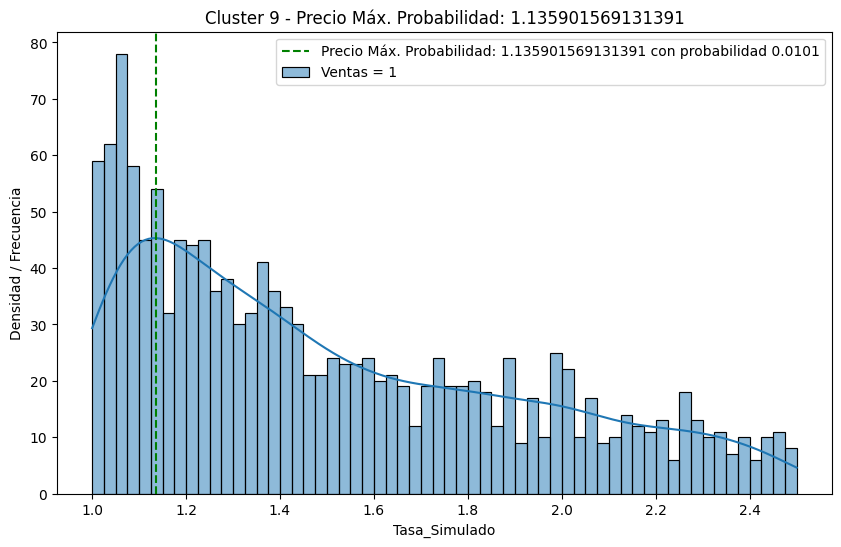

In [138]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear el directorio de salida si no existe
output_dir = 'estimacion-elasticidad'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Función para normalizar la densidad y calcular la probabilidad
def calculate_probability(kde_df):
    # Sumar todas las densidades para obtener la densidad total
    total_density = kde_df['Density'].sum()
    
    # Normalizar cada valor de densidad dividiendo por la suma total
    kde_df['Probability'] = kde_df['Density'] / total_density
    
    return kde_df

# Bucle a través de cada cluster
for cluster_num in range(0, 108):
    # Filtrar el dataframe para el cluster actual donde 'venta' es 1
    df_cluster_ventas_1 = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 1)]
    
    if df_cluster_ventas_1.empty:
        continue
    
    # Estimación de KDE para ventas = 1
    plt.figure(figsize=(10, 6))
    hist_plot_1 = sns.histplot(
        data=df_cluster_ventas_1,
        x='Tasa_Simulado',
        bins=60,
        kde=True,
        label="Ventas = 1"
    )
    
    # Extraer datos de KDE para ventas = 1
    kde_data_1 = hist_plot_1.lines[0].get_data()
    kde_df_1 = pd.DataFrame({'Tasa_Simulado': kde_data_1[0], 'Density': kde_data_1[1]})
    
    # Normalizar la densidad para obtener probabilidades
    kde_df_1 = calculate_probability(kde_df_1)
    
    # Encontrar el precio con la máxima probabilidad de aceptación
    max_probability_index = kde_df_1['Probability'].idxmax()
    max_price = kde_df_1.loc[max_probability_index, 'Tasa_Simulado']
    max_probability = kde_df_1.loc[max_probability_index, 'Probability']
    
    # Graficar el KDE y el punto con la máxima probabilidad
    plt.axvline(x=max_price, color='green', linestyle='--', label=f'Precio Máx. Probabilidad: {max_price} con probabilidad {max_probability:.4f}')
    plt.title(f'Cluster {cluster_num} - Precio Máx. Probabilidad: {max_price}')
    plt.xlabel('Tasa_Simulado')
    plt.ylabel('Densidad / Frecuencia')
    plt.legend()
    
    # Guardar el gráfico
    plt.savefig(os.path.join(output_dir, f'cluster_{cluster_num}_max_probability_acceptance.png'))
    plt.close()

    # Imprimir el precio con mayor probabilidad y el valor de esa probabilidad
    print(f'Cluster {cluster_num}: Precio de Máx. Probabilidad de aceptacion = {max_price}, Probabilidad Máxima = {max_probability:.4f}')


NameError: name 'df_cluster' is not defined

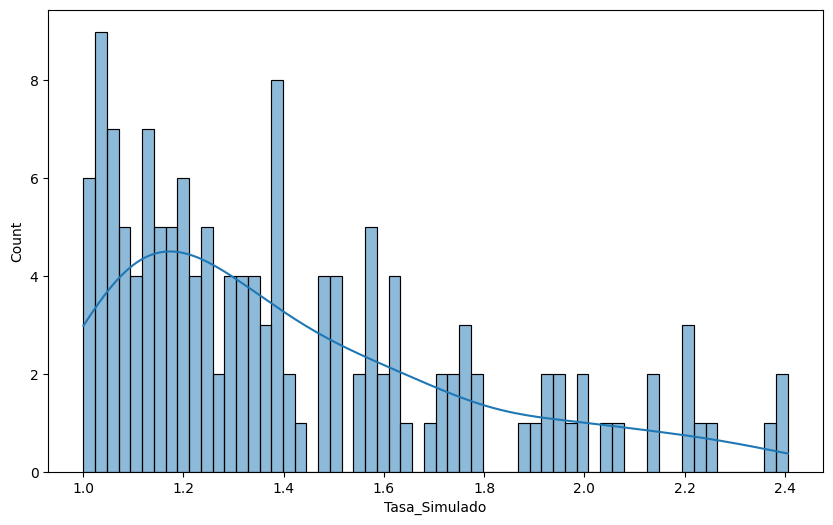

In [139]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

lista_revenue = []
# Crear el directorio de salida si no existe
output_dir = 'estimacion-elasticidad'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Función para calcular la probabilidad de aceptación
def calculate_probability(kde_df):
    total_density = kde_df['Density'].sum()  # Sumar todas las densidades
    kde_df['Probability'] = kde_df['Density'] / total_density  # Normalizar la densidad para obtener la probabilidad
    return kde_df

# Función para calcular el revenue potencial
def calculate_potential_revenue(kde_df, df_cluster):
    i = kde_df['Tasa_Simulado']  # Tasa de simulación (precio)
    n = df_cluster['Plazo_Simulado'].mean()  # Plazo medio de los créditos
    vp = df_cluster['Monto_Simulado'].mean()  # Valor presente medio (monto del crédito)
    
    # Fórmula para calcular el revenue potencial
    kde_df['Potential_Revenue'] = vp * ((i * (1 + i) ** n) / ((1 + i) ** n - 1))
    
    return kde_df

# Función para calcular el revenue esperado basado en la probabilidad
def calculate_expected_revenue(kde_df, df_cluster):
    num_clients = df_cluster['rut'].nunique()  # Número de clientes en el cluster
    kde_df['Expected_Revenue'] = (kde_df['Probability'] * kde_df['Potential_Revenue']) * num_clients # Revenue esperado = probabilidad * revenue potencial
    return kde_df

# Bucle a través de cada cluster
for cluster_num in range(0, 108):
    # Filtrar el dataframe para el cluster actual donde 'venta' es 1
    df_cluster_ventas_1 = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 1)]
    
    if df_cluster_ventas_1.empty:
        continue
    
    # Estimación de KDE para ventas = 1
    plt.figure(figsize=(10, 6))
    hist_plot_1 = sns.histplot(
        data=df_cluster_ventas_1,
        x='Tasa_Simulado',
        bins=60,
        kde=True,
        label="Ventas = 1"
    )
    
    # Extraer datos de KDE para ventas = 1
    kde_data_1 = hist_plot_1.lines[0].get_data()
    kde_df_1 = pd.DataFrame({'Tasa_Simulado': kde_data_1[0], 'Density': kde_data_1[1]})
    
    # Calcular la probabilidad de aceptación normalizando la densidad
    kde_df_1 = calculate_probability(kde_df_1)
    
    # Calcular el revenue potencial usando la fórmula proporcionada
    kde_df_1 = calculate_potential_revenue(kde_df_1, df_cluster_ventas_1)
    
    # Calcular el revenue esperado
    kde_df_1 = calculate_expected_revenue(kde_df_1, df_cluster_ventas_1)
    
    # Encontrar el precio que maximiza el revenue esperado
    max_expected_revenue_index = kde_df_1['Expected_Revenue'].idxmax()
    max_price = kde_df_1.loc[max_expected_revenue_index, 'Tasa_Simulado']
    max_expected_revenue = kde_df_1.loc[max_expected_revenue_index, 'Expected_Revenue']
    
    # Graficar el KDE y el punto con el máximo revenue esperado
    plt.axvline(x=max_price, color='green', linestyle='--', label=f'Precio Máx. Revenue Esperado: {max_price:.2f} con revenue {max_expected_revenue:.2f}')
    plt.title(f'Cluster {cluster_num} - Precio Máx. Revenue Esperado: {max_price:.2f}')
    plt.xlabel('Tasa_Simulado')
    plt.ylabel('Densidad / Frecuencia')
    plt.legend()
    
    # Guardar el gráfico
    plt.savefig(os.path.join(output_dir, f'cluster_{cluster_num}_max_expected_revenue.png'))
    plt.close()

    # Imprimir el precio con el mayor revenue esperado y el valor de ese revenue
    print(f'Cluster {cluster_num}: Precio Máx. Revenue Esperado = {max_price:.2f}, Revenue Esperado Máximo = {max_expected_revenue:.2f}')
    lista_revenue.append(max_expected_revenue)

print(f"El revenue total esperado es: {sum(lista_revenue)}")


# 11. CLUSTERING DEFINITIVO POR POLITICAS 2


In [111]:
df_informacion_de_clientes_procesados_cluster_definitivo = df_informacion_de_clientes[['rut', 'Categoria_Digital', 'Edad', 'Genero', 'Renta', 'Propension', 'Probabilidad_No_Pago', 'Elasticidad_Precios']].copy()


In [112]:
import pandas as pd

# Create a copy of the dataframe to work with
df = df_informacion_de_clientes_procesados_cluster_definitivo.copy()

# Propensión
df['Categoria_Propenso'] = pd.qcut(df['Propension'], 3, labels=['Propension baja', 'Propension media', 'Propension alta'])

# Probabilidad_No_Pago
df['Categoria_Probabilidad_No_Pago'] = pd.cut(df['Probabilidad_No_Pago'], 
                                              bins=[-float('inf'), 0.0011, 0.00149, 0.005, 0.006, float('inf')],
                                              labels=['Muy buen pagador', 'Buen pagador', 'Pagador neutro', 'Mal pagador', 'Muy mal pagador'])

# Edad
df['Categoria_Edad'] = pd.cut(df['Edad'], 
                              bins=[-float('inf'), 35, 60, float('inf')],
                              labels=['Joven', 'Adulto', 'Adulto Mayor'])

# Renta
df_unicos_renta = df[['rut', 'Renta']].drop_duplicates()
df_unicos_renta['Percentil_Renta'] = pd.qcut(df_unicos_renta['Renta'], 100, labels=False) + 1
df_unicos_renta['Categoria_Renta'] = pd.cut(df_unicos_renta['Percentil_Renta'], 
                                            bins=[-float('inf'), 30, 80, float('inf')],
                                            labels=['Renta Baja', 'Renta Media', 'Renta Alta'])

# Merge the renta categories back to the main dataframe
df = df.merge(df_unicos_renta[['rut', 'Categoria_Renta']], on='rut', how='left')

# Display the dataframe with the new columns
df

,rut,Categoria_Digital,Edad,Genero,Renta,Propension,Probabilidad_No_Pago,Elasticidad_Precios,Categoria_Propenso,Categoria_Probabilidad_No_Pago,Categoria_Edad,Categoria_Renta
0,1,Cliente no Digital,30.0,Masculino,6.258183e+05,0.997340,0.028445,Alta,Propension alta,Muy mal pagador,Joven,Renta Media
1,2,Cliente no Digital,41.0,Femenino,3.172616e+05,0.291601,0.014320,Baja,Propension baja,Muy mal pagador,Adulto,Renta Baja
2,3,Cliente no Digital,38.0,Femenino,1.240551e+07,0.685085,0.002156,Baja,Propension alta,Pagador neutro,Adulto,Renta Alta
3,4,Cliente no Digital,57.0,Masculino,5.441466e+05,0.914672,0.034418,Alta,Propension alta,Muy mal pagador,Adulto,Renta Baja
4,5,Cliente Digital,26.0,Masculino,1.870225e+05,0.425077,0.014978,Media,Propension media,Muy mal pagador,Joven,Renta Baja
...,...,...,...,...,...,...,...,...,...,...,...,...
543646,543647,Cliente Digital,29.0,Femenino,1.176598e+05,0.144657,0.037291,Baja,Propension baja,Muy mal pagador,Joven,Renta Baja
543647,543648,Cliente no Digital,31.0,Masculino,1.558612e+06,0.740170,0.035877,Baja,Propension alta,Muy mal pagador,Joven,Renta Media
543648,543649,Cliente no Digital,49.0,Masculino,9.449508e+05,0.255285,0.023306,Media,Propension baja,Muy mal pagador,Adulto,Renta Media
543649,543650,Cliente no Digital,40.0,Femenino,1.039964e+06,0.709086,0.015121,Media,Propension alta,Muy mal pagador,Adulto,Renta Media


In [113]:
# Check for NaN values in the DataFrame
nan_summary = df.isnull().any()

# Print the summary
print(nan_summary)

rut                               False
Categoria_Digital                 False
Edad                              False
Genero                            False
Renta                             False
Propension                        False
Probabilidad_No_Pago              False
Elasticidad_Precios               False
Categoria_Propenso                False
Categoria_Probabilidad_No_Pago    False
Categoria_Edad                    False
Categoria_Renta                   False
dtype: bool


In [114]:
# Concatenate the specified variables into a new column
df['categoria_clusterizacion'] = (
    df['Categoria_Digital'].astype(str) + ' ' +
    df['Categoria_Edad'].astype(str) + ' de genero ' +
    df['Genero'].astype(str) + ' con ' +
    df['Categoria_Propenso'].astype(str) + ' con una ' +
    df['Categoria_Renta'].astype(str) + 'de elasticidad ' +
    df['Elasticidad_Precios'].astype(str)
)

# Display the dataframe with the new column
df.head()

,rut,Categoria_Digital,Edad,Genero,Renta,Propension,Probabilidad_No_Pago,Elasticidad_Precios,Categoria_Propenso,Categoria_Probabilidad_No_Pago,Categoria_Edad,Categoria_Renta,categoria_clusterizacion
0,1,Cliente no Digital,30.0,Masculino,6.258183e+05,0.997340,0.028445,Alta,Propension alta,Muy mal pagador,Joven,Renta Media,Cliente no Digital Joven de genero Masculino c...
1,2,Cliente no Digital,41.0,Femenino,3.172616e+05,0.291601,0.014320,Baja,Propension baja,Muy mal pagador,Adulto,Renta Baja,Cliente no Digital Adulto de genero Femenino c...
2,3,Cliente no Digital,38.0,Femenino,1.240551e+07,0.685085,0.002156,Baja,Propension alta,Pagador neutro,Adulto,Renta Alta,Cliente no Digital Adulto de genero Femenino c...
3,4,Cliente no Digital,57.0,Masculino,5.441466e+05,0.914672,0.034418,Alta,Propension alta,Muy mal pagador,Adulto,Renta Baja,Cliente no Digital Adulto de genero Masculino ...
4,5,Cliente Digital,26.0,Masculino,1.870225e+05,0.425077,0.014978,Media,Propension media,Muy mal pagador,Joven,Renta Baja,Cliente Digital Joven de genero Masculino con ...


In [115]:
# Assign a unique number to each unique entry in 'categoria_clusterizacion'
df['categoria_clusterizacion_numerica'] = df['categoria_clusterizacion'].astype('category').cat.codes

# Display the dataframe with the new column
df.head()

,rut,Categoria_Digital,Edad,Genero,Renta,Propension,Probabilidad_No_Pago,Elasticidad_Precios,Categoria_Propenso,Categoria_Probabilidad_No_Pago,Categoria_Edad,Categoria_Renta,categoria_clusterizacion,categoria_clusterizacion_numerica
0,1,Cliente no Digital,30.0,Masculino,6.258183e+05,0.997340,0.028445,Alta,Propension alta,Muy mal pagador,Joven,Renta Media,Cliente no Digital Joven de genero Masculino c...,301
1,2,Cliente no Digital,41.0,Femenino,3.172616e+05,0.291601,0.014320,Baja,Propension baja,Muy mal pagador,Adulto,Renta Baja,Cliente no Digital Adulto de genero Femenino c...,227
2,3,Cliente no Digital,38.0,Femenino,1.240551e+07,0.685085,0.002156,Baja,Propension alta,Pagador neutro,Adulto,Renta Alta,Cliente no Digital Adulto de genero Femenino c...,215
3,4,Cliente no Digital,57.0,Masculino,5.441466e+05,0.914672,0.034418,Alta,Propension alta,Muy mal pagador,Adulto,Renta Baja,Cliente no Digital Adulto de genero Masculino ...,244
4,5,Cliente Digital,26.0,Masculino,1.870225e+05,0.425077,0.014978,Media,Propension media,Muy mal pagador,Joven,Renta Baja,Cliente Digital Joven de genero Masculino con ...,156


In [116]:
unique_count = df['categoria_clusterizacion_numerica'].nunique()
print(f"Number of unique values in 'categoria_clusterizacion_numerica': {unique_count}")

Number of unique values in 'categoria_clusterizacion_numerica': 322


In [117]:
asignacion_clusters = df[['rut', 'categoria_clusterizacion', 'categoria_clusterizacion_numerica']].copy()

In [88]:
asignacion_clusters.to_csv('asignacion_clusters.csv', index=False)

C:\Users\7coto\AppData\Local\Temp\ipykernel_11980\1949779085.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


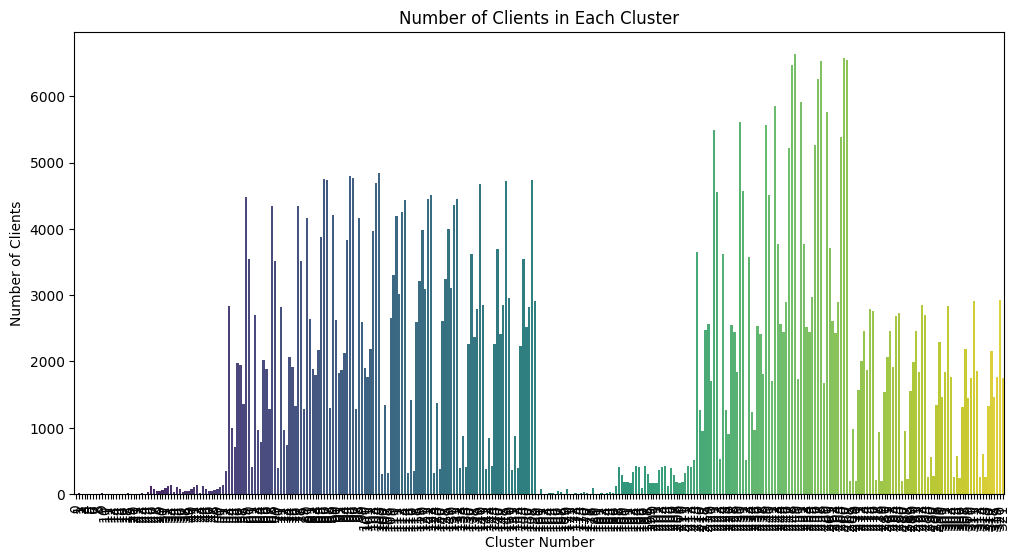

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of clients in each cluster
cluster_counts = df['categoria_clusterizacion_numerica'].value_counts()

# Plot the number of clients in each cluster
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Clients')
plt.title('Number of Clients in Each Cluster')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

## 11.2 Estimacion de curvas de elasticidad por cluster

In [119]:
df_estimar_elasticidad = pd.merge(df_simulaciones_e_informacion_de_clientes_ventas, asignacion_clusters, on='rut', how='left')

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each cluster from 1 to 108 (currently just cluster 1 for this example)
for cluster_num in range(0, 322):
    # Filter the dataframe for the current cluster and where 'venta' is 1
    df_cluster_ventas = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 1)]
    
    if df_cluster_ventas.empty:
        continue
    
    # Get the cluster description
    cluster_description = df_cluster_ventas['categoria_clusterizacion'].iloc[0]
    
    # Create the histogram plot for 'Tasa_Simulado'
    plt.figure(figsize=(10, 6))
    hist_plot = sns.histplot(
        data=df_cluster_ventas,
        x='Tasa_Simulado',
        bins=60,  # You can adjust the number of bins as needed
        kde=True  # Add a kernel density estimate
    )

    # Set plot title and labels
    hist_plot.set_title(f'Distribution of Tasa_Simulado for Cluster {cluster_num} (Ventas = 1)\n Descripcion de cluster: {cluster_description}')
    hist_plot.set_xlabel('Tasa_Simulado')
    hist_plot.set_ylabel('Frequency')

    # Add cluster description text to the plot
    # Adjust the position of the text
    # plt.text(
    #     0.95, 0.95,  # X and Y positions in axes coordinates (adjusted to fit inside plot)
    #     f'Description: {cluster_description}',  # Add a prefix for clarity
    #     transform=plt.gca().transAxes,  # Position relative to axes
    #     fontsize=12,  # Font size
    #     verticalalignment='top',  # Align text at the top
    #     horizontalalignment='right',  # Align to the right for better positioning
    #     bbox=dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round,pad=0.5')  # Use a box around text
    # )

    # Extract KDE data
    kde_data = hist_plot.lines[0].get_data()
    kde_df = pd.DataFrame({'Tasa_Simulado': kde_data[0], 'Density': kde_data[1]})

    print(kde_df)


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Create the output directory if it doesn't exist
output_dir = 'estimacion-elasticidad-v1-v0'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through each cluster from 1 to 108
for cluster_num in range(0, 108):
    # Filter the dataframe for the current cluster and where 'venta' is 1
    df_cluster_ventas_1 = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 1)]
    df_cluster_ventas_0 = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 0)]
    
    if df_cluster_ventas_1.empty and df_cluster_ventas_0.empty:
        continue

    # Get the cluster description
    if not df_cluster_ventas_1.empty:
        cluster_description = df_cluster_ventas_1['categoria_clusterizacion'].iloc[0]
    else:
        cluster_description = df_cluster_ventas_0['categoria_clusterizacion'].iloc[0]

    # Create the histogram plot for 'Tasa_Simulado' (Ventas = 1)
    plt.figure(figsize=(10, 6))
    
    # Plot for ventas = 1 (default blue color)
    if not df_cluster_ventas_1.empty:
        hist_plot_1 = sns.histplot(
            data=df_cluster_ventas_1,
            x='Tasa_Simulado',
            bins=60,
            kde=True,
            label="Ventas = 1"  # Add label for legend
        )

    # Plot for ventas = 0 (red color with reduced opacity)
    if not df_cluster_ventas_0.empty:
        hist_plot_0 = sns.histplot(
            data=df_cluster_ventas_0,
            x='Tasa_Simulado',
            bins=60,
            kde=True,
            color="red",  # Make the KDE line red
            line_kws={'alpha': 0.5},  # Reduce opacity for the KDE line
            label="Ventas = 0"  # Add label for legend
        )
    
    # Set plot title and labels
    plt.title(f'Distribution of Tasa_Simulado for Cluster {cluster_num}\n Descripción de cluster: {cluster_description}')
    plt.xlabel('Tasa_Simulado')
    plt.ylabel('Frequency')
    
    # Add a legend to differentiate between ventas = 1 and ventas = 0
    plt.legend()

    # Save the plot as a PNG file
    plt.savefig(os.path.join(output_dir, f'cluster_{cluster_num}_estimacion_ventas_comparison.png'))

    # Close the plot to free memory
    plt.close()


Este código tiene como objetivo calcular el **precio que maximiza la probabilidad de aceptación** de un crédito para cada cluster de clientes. La probabilidad de aceptación se basa en la **estimación de densidad kernel (KDE)** de la tasa simulada (`Tasa_Simulado`), que representa la demanda para `ventas = 1` (clientes que aceptan el crédito). Primero, se calcula la **densidad** para cada precio en un cluster específico. Luego, se normaliza la densidad dividiendo cada valor de densidad por la suma total de todas las densidades, lo que da como resultado una **probabilidad** entre 0 y 1. Esta probabilidad refleja la probabilidad relativa de que un cliente acepte el crédito a un determinado precio. Finalmente, el código identifica el precio con la mayor probabilidad de aceptación y lo visualiza en un gráfico, destacando este precio con una línea discontinua verde. El gráfico se guarda para cada cluster y el código imprime el precio con la mayor probabilidad y su valor de probabilidad correspondiente.


In [93]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Función para normalizar la densidad y calcular la probabilidad
def calculate_probability(kde_df):
    # Sumar todas las densidades para obtener la densidad total
    total_density = kde_df['Density'].sum()
    
    # Normalizar cada valor de densidad dividiendo por la suma total
    kde_df['Probability'] = kde_df['Density'] / total_density
    
    return kde_df

# Bucle a través de cada cluster
for cluster_num in range(0, 322):
    # Filtrar el dataframe para el cluster actual donde 'venta' es 1
    df_cluster_ventas_1 = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 1)]
    
    if df_cluster_ventas_1.empty:
        continue
    
    # Estimación de KDE para ventas = 1
    plt.figure(figsize=(10, 6))
    hist_plot_1 = sns.histplot(
        data=df_cluster_ventas_1,
        x='Tasa_Simulado',
        bins=60,
        kde=True,
        label="Ventas = 1"
    )
    
    # Extraer datos de KDE para ventas = 1
    kde_data_1 = hist_plot_1.lines[0].get_data()
    kde_df_1 = pd.DataFrame({'Tasa_Simulado': kde_data_1[0], 'Density': kde_data_1[1]})
    
    # Normalizar la densidad para obtener probabilidades
    kde_df_1 = calculate_probability(kde_df_1)
    
    # Encontrar el precio con la máxima probabilidad de aceptación
    max_probability_index = kde_df_1['Probability'].idxmax()
    max_price = kde_df_1.loc[max_probability_index, 'Tasa_Simulado']
    max_probability = kde_df_1.loc[max_probability_index, 'Probability']
    

    # Imprimir el precio con mayor probabilidad y el valor de esa probabilidad
    print(f'Cluster {cluster_num}: Precio Máx. Probabilidad = {max_price}, Probabilidad Máxima = {max_probability:.4f}')
    plt.close()


Cluster 0: Precio Máx. Probabilidad = 1.4329453095673128, Probabilidad Máxima = 0.0064
Cluster 1: Precio Máx. Probabilidad = 1.1284645176944106, Probabilidad Máxima = 0.0121
Cluster 2: Precio Máx. Probabilidad = 1.3975576843402175, Probabilidad Máxima = 0.0061
Cluster 3: Precio Máx. Probabilidad = 1.3046607485019355, Probabilidad Máxima = 0.0064
Cluster 4: Precio Máx. Probabilidad = 1.1751785128637584, Probabilidad Máxima = 0.0083
Cluster 5: Precio Máx. Probabilidad = 1.3144818611686182, Probabilidad Máxima = 0.0065
Cluster 6: Precio Máx. Probabilidad = 1.6179192715891981, Probabilidad Máxima = 0.0070
Cluster 7: Precio Máx. Probabilidad = 1.1229204518602225, Probabilidad Máxima = 0.0149
Cluster 8: Precio Máx. Probabilidad = 1.3812441145514651, Probabilidad Máxima = 0.0064
Cluster 9: Precio Máx. Probabilidad = 1.2087293253150042, Probabilidad Máxima = 0.0097
Cluster 10: Precio Máx. Probabilidad = 1.294614029114253, Probabilidad Máxima = 0.0064
Cluster 11: Precio Máx. Probabilidad = 2.18

In [124]:
df_estimar_elasticidad['rut'].nunique()

543651

In [127]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

lista_revenue = []
# Crear el directorio de salida si no existe
output_dir = 'estimacion-elasticidad2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Función para calcular la probabilidad de aceptación
def calculate_probability(kde_df):
    total_density = kde_df['Density'].sum()  # Sumar todas las densidades
    kde_df['Probability'] = kde_df['Density'] / total_density  # Normalizar la densidad para obtener la probabilidad
    return kde_df

# Función para calcular el revenue potencial
def calculate_potential_revenue(kde_df, df_cluster):
    i = kde_df['Tasa_Simulado']  # Tasa de simulación (precio)
    n = df_cluster['Plazo_Simulado'].mean()  # Plazo medio de los créditos
    vp = df_cluster['Monto_Simulado'].mean()  # Valor presente medio (monto del crédito)
    
    # Fórmula para calcular el revenue potencial
    kde_df['Potential_Revenue'] = vp * ((i * ((1 + i) ** n)) / (((1 + i) ** n) - 1))
    
    return kde_df

# Función para calcular el revenue esperado basado en la probabilidad
def calculate_expected_revenue(kde_df, df_cluster):
    num_clients = df_cluster['rut'].nunique()  # Número de clientes en el cluster
    kde_df['Expected_Revenue'] = (kde_df['Probability'] * kde_df['Potential_Revenue']) * num_clients  # Revenue esperado = probabilidad * revenue potencial * número de clientes
    return kde_df

# Bucle a través de cada cluster
for cluster_num in range(0, 322):
    # Filtrar el dataframe para el cluster actual donde 'venta' es 1
    df_cluster_ventas_1 = df_estimar_elasticidad[(df_estimar_elasticidad['categoria_clusterizacion_numerica'] == cluster_num) & (df_estimar_elasticidad['venta'] == 1)]
    
    if df_cluster_ventas_1.empty:
        continue
    
    # Estimación de KDE para ventas = 1
    plt.figure(figsize=(10, 6))
    hist_plot_1 = sns.histplot(
        data=df_cluster_ventas_1,
        x='Tasa_Simulado',
        bins=60,
        kde=True,
        label="Ventas = 1"
    )
    
    # Extraer datos de KDE para ventas = 1
    kde_data_1 = hist_plot_1.lines[0].get_data()
    kde_df_1 = pd.DataFrame({'Tasa_Simulado': kde_data_1[0], 'Density': kde_data_1[1]})
    
    # Calcular la probabilidad de aceptación normalizando la densidad
    kde_df_1 = calculate_probability(kde_df_1)
    
    # Calcular el revenue potencial usando la fórmula proporcionada
    kde_df_1 = calculate_potential_revenue(kde_df_1, df_cluster_ventas_1)
    
    # Calcular el revenue esperado
    kde_df_1 = calculate_expected_revenue(kde_df_1, df_cluster_ventas_1)
    
    # Encontrar el precio que maximiza el revenue esperado
    max_expected_revenue_index = kde_df_1['Expected_Revenue'].idxmax()
    max_price = kde_df_1.loc[max_expected_revenue_index, 'Tasa_Simulado']
    max_expected_revenue = kde_df_1.loc[max_expected_revenue_index, 'Expected_Revenue']
    
    # Graficar el KDE y el punto con el máximo revenue esperado
    plt.axvline(x=max_price, color='green', linestyle='--', label=f'Precio Máx. Revenue Esperado: {max_price:.2f} con revenue {max_expected_revenue:.2f}')
    plt.title(f'Cluster {cluster_num} - Precio Máx. Revenue Esperado: {max_price:.2f}')
    plt.xlabel('Tasa_Simulado')
    plt.ylabel('Densidad / Frecuencia')
    plt.legend()
    
    # Guardar el gráfico
    plt.savefig(os.path.join(output_dir, f'cluster_{cluster_num}_max_expected_revenue.png'))
    plt.close()

    # Imprimir el precio con el mayor revenue esperado y el valor de ese revenue
    print(f'Cluster {cluster_num}: Precio Máx. Revenue Esperado = {max_price:.2f}, Revenue Esperado Máximo = {max_expected_revenue:.2f}')
    lista_revenue.append(max_expected_revenue)

print(f"El revenue total esperado es: {sum(lista_revenue)}")


Cluster 0: Precio Máx. Revenue Esperado = 1.56, Revenue Esperado Máximo = 231853.30
Cluster 1: Precio Máx. Revenue Esperado = 1.16, Revenue Esperado Máximo = 21578049.52
Cluster 2: Precio Máx. Revenue Esperado = 1.78, Revenue Esperado Máximo = 435930.52
Cluster 3: Precio Máx. Revenue Esperado = 1.34, Revenue Esperado Máximo = 6407.32
Cluster 4: Precio Máx. Revenue Esperado = 1.26, Revenue Esperado Máximo = 41858.02
Cluster 5: Precio Máx. Revenue Esperado = 2.09, Revenue Esperado Máximo = 32503.99
Cluster 6: Precio Máx. Revenue Esperado = 1.69, Revenue Esperado Máximo = 47030.52
Cluster 7: Precio Máx. Revenue Esperado = 1.15, Revenue Esperado Máximo = 525483.92
Cluster 8: Precio Máx. Revenue Esperado = 2.14, Revenue Esperado Máximo = 182669.03
Cluster 9: Precio Máx. Revenue Esperado = 1.24, Revenue Esperado Máximo = 18889594.57
Cluster 10: Precio Máx. Revenue Esperado = 1.38, Revenue Esperado Máximo = 248079.18
Cluster 11: Precio Máx. Revenue Esperado = 2.29, Revenue Esperado Máximo = 2